In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
#plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%load_ext watermark

# Identifying Credit Card Default with Machine Learning

## BONUS: Getting the data and preparing for book

This is a part not covered in the book. We download the considered dataset from the website of the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). The dataset originally does not contain missing values and the categorical variables are already encoded as numbers. To show the entire pipeline of working and preparing potentially messy data, we apply some transformations:

* we encoded the gender, education and marital status related variables back to strings
* we introduced missing values to some observations (0.5% of the entire sample, selected randomly per column - the total percentage of rows with at least one missing value will be higher)
* some observed values for features such as level of education, payments status etc. are outside of the range of possible categories defined by the authors. As this problem affects many observations, we encode new, undescribed categories as either 'Others' (when there was already such a category) or 'Unknown' (in the case of payment status).

The reason for selecting only a small fraction of values to be missing is that we do not want to significantly change the underlying structure/patterns in the data.

In [ ]:
import pandas as pd
import numpy as np
import random

In [ ]:
# downloading the data 
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

In [ ]:
df = pd.read_excel('default of credit card clients.xls', skiprows=1, index_col=0)

In [ ]:
# loading the data from Excel
df = pd.read_excel('default of credit card clients.xls', skiprows=1, index_col=0)

# rename columns
df.columns = df.columns.str.lower().str.replace(" ", "_")

months = ['sep', 'aug', 'jul', 'jun', 'may', 'apr']
variables = ['payment_status', 'bill_statement', 'previous_payment']
new_column_names = [x + '_' + y for x in variables for y in months]
rename_dict = {x: y for x, y in zip(df.loc[:, 'pay_0':'pay_amt6'].columns, new_column_names)}
df.rename(columns=rename_dict, inplace=True)


# creating dicts to map number to strings
gender_dict = {1: 'Male', 
               2: 'Female'}
education_dict = {0: 'Others',
                  1: 'Graduate school', 
                  2: 'University', 
                  3: 'High school', 
                  4: 'Others',
                  5: 'Others',
                  6: 'Others'}
marital_status_dict = {0: 'Others', 
                       1: 'Married', 
                       2: 'Single', 
                       3: 'Others'}
payment_status = {-2: 'Unknown',
                  -1: 'Payed duly',
                  0: 'Unknown',
                  1: 'Payment delayed 1 month',
                  2: 'Payment delayed 2 months',
                  3: 'Payment delayed 3 months',
                  4: 'Payment delayed 4 months',
                  5: 'Payment delayed 5 months',
                  6: 'Payment delayed 6 months',
                  7: 'Payment delayed 7 months',
                  8: 'Payment delayed 8 months',
                  9: 'Payment delayed >= 9 months'}

# # map numbers to strings
df.sex = df.sex.map(gender_dict)
df.education = df.education.map(education_dict)
df.marriage = df.marriage.map(marital_status_dict)

for column in [x for x in df.columns if ('status' in x)]:
    df[column] = df[column].map(payment_status)

# define the ratio of missing values to introduce
RATIO_MISSING = 0.005

# input missing values to selected columns
random_state = np.random.RandomState(42)
for column in ['sex', 'education', 'marriage', 'age']:
    df.loc[df.sample(frac=RATIO_MISSING, random_state=random_state).index, column] = ''

# reset index
df.reset_index(drop=True, inplace=True)

# save to csv
df.to_csv('credit_card_default.csv')

## Loading the data and managing data types

### How to do it...

1. Import libraries:

In [ ]:
import pandas as pd

In [ ]:
%watermark --iversions

2. Preview the CSV file:

In [ ]:
!head -n 5 credit_card_default.csv

3. Load the data from the CSV file:

In [ ]:
df = pd.read_csv('credit_card_default.csv', index_col=0, na_values='')
print(f'The DataFrame has {len(df)} rows and {df.shape[1]} columns.')
df.head()

4. Separate the features from the target:

In [ ]:
X = df.copy()
y = X.pop('default_payment_next_month')

### There's more

In [ ]:
df.dtypes

In [ ]:
def get_df_memory_usage(df, top_columns=5):
    '''
    Function for quick analysis of a pandas DataFrame's memory usage.
    It prints the top `top_columns` columns in terms of memory usage 
    and the total usage of the DataFrame.
    
    Parameters
    ------------
    df : pd.DataFrame
        DataFrame to be inspected
    top_columns : int
        Number of top columns (in terms of memory used) to display
    '''
    print('Memory usage ----')
    memory_per_column = df.memory_usage(deep=True) / 1024 ** 2
    print(f'Top {top_columns} columns by memory (Mb):')
    print(memory_per_column.sort_values(ascending=False).head(top_columns))
    print(f'Total size: {memory_per_column.sum():.4f} Mb')

In [ ]:
get_df_memory_usage(df, 5)

In [ ]:
df_cat = df.copy()
object_columns = df_cat.select_dtypes(include='object').columns
df_cat[object_columns] = df_cat[object_columns].astype('category')

In [ ]:
get_df_memory_usage(df_cat)

In [ ]:
column_dtypes = {'education': 'category', 
                 'marriage': 'category', 
                 'sex': 'category',
                 'payment_status_sep': 'category', 
                 'payment_status_aug': 'category', 
                 'payment_status_jul': 'category',       
                 'payment_status_jun': 'category', 
                 'payment_status_may': 'category', 
                 'payment_status_apr': 'category'}
df_cat2 = pd.read_csv('credit_card_default.csv', index_col=0, 
                      na_values='', dtype=column_dtypes)

In [ ]:
get_df_memory_usage(df_cat2)

In [ ]:
df_cat.equals(df_cat2)

## Exploratory Data Analysis

### How to do it...

1. Import libraries:

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.io as pio

In [ ]:
%watermark --iversions

2. Get summary statistics for numeric variables:

In [ ]:
df.describe().transpose().round(2)

3. Get summary statistics for categorical variables:

In [ ]:
df.describe(include='object').transpose()

4. Plot the distribution of age and additionally split it by gender:

In [ ]:
ax = sns.distplot(df.age.dropna(), )
ax.set_title('Distribution of age');

In [ ]:
px.histogram(df, x='age', title = 'Distribution of age')

In [ ]:
fig, ax = plt.subplots()
sns.distplot(df.loc[df.sex=='Male', 'age'].dropna(), hist=False, color='green', ax=ax, label='Male')
sns.distplot(df.loc[df.sex=='Female', 'age'].dropna(), hist=False, color='blue', ax=ax, label='Female')
ax.set_title('Distribution of age')
ax.legend(title='Gender:');

5. Plot a `pairplot` of selected variables:

In [ ]:
pair_plot = sns.pairplot(df[['age', 'limit_bal', 'previous_payment_sep']])
pair_plot.fig.suptitle('Pairplot of selected variables', y=1.05);

In [ ]:
pair_plot = sns.pairplot(df[['sex', 'age', 'limit_bal', 'previous_payment_sep']], hue='sex')
pair_plot.fig.suptitle('Pairplot of selected variables', y=1.05);

6. Define and run a function plotting the correlation heatmap:

In [ ]:
def plot_correlation_matrix(df):
    # temporarily change style
    sns.set(style="white")
    # calculate the correlation matrix (only numeric)
    corr = df.select_dtypes(include='number').corr()
    # mask the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # set up the matplotlib figure
    fig, ax = plt.subplots()
    # set up custom diverging colormap
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    # plot the heatmap
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_title('Correlation Matrix', fontsize=16)
    # change back to darkgrid style
    sns.set(style="darkgrid")

In [ ]:
plot_correlation_matrix(df)

In [ ]:
df.select_dtypes(include='number').corr()[['default_payment_next_month']]

7. Plot distributions of age and limit balance per age and gender:

In [ ]:
ax = sns.violinplot(x="education", y="age", hue="sex", split=False, data=df)
ax.set_title('Distribution of age amount per education level', fontsize=16);


In [ ]:
ax = sns.violinplot(x="education", y="limit_bal", hue="sex", split=True, data=df)
ax.set_title('Distribution of limit balance per education level', fontsize=16);


8. Investigate the distribution of the target variables per gender and education level:

In [ ]:
ax = sns.countplot('default_payment_next_month', hue='sex', data=df, orient='h')
ax.set_title('Distribution of the target variable', fontsize=16);

In [ ]:
ax = df.groupby("education")['default_payment_next_month'] \
       .value_counts(normalize=True) \
       .unstack() \
       .plot(kind='barh', stacked='True')
ax.set_title('Percentage of default per education level', fontsize=16)
ax.legend(title='Default', bbox_to_anchor=(1,1)) 


### There's more

In [ ]:
import pandas_profiling
df.profile_report()

## Splitting the data into training and test sets

### How to do it...

1. Import the function from `sklearn`:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
%watermark --iversions

2. Split the data into training and test sets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3. Split the data into training and test sets without shuffling:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

4. Split the data into training and test sets with stratification:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

5. Verify that the ratio of the target is preserved:

In [ ]:
y_train.value_counts(normalize=True)

In [ ]:
y_test.value_counts(normalize=True)

### There's more

In [ ]:
# define the size of the validation and test sets
VALID_SIZE = 0.1
TEST_SIZE = 0.2

# create the initial split - training and temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(VALID_SIZE + TEST_SIZE), stratify=y, random_state=42)

# calculate the new test size
NEW_TEST_SIZE = np.around(TEST_SIZE / (VALID_SIZE + TEST_SIZE), 2)

# create the valid and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=NEW_TEST_SIZE, stratify=y_temp, random_state=42)

## Dealing with the missing values

### How to do it...

1. Import libraries:

In [ ]:
import pandas as pd 
import missingno
from sklearn.impute import SimpleImputer

In [ ]:
%watermark --iversions

2. Inspect the information about the DataFrame:

In [ ]:
X.info()

3. Visualize the nullity of the DataFrame:

In [ ]:
missingno.matrix(X)

4. Define columns with missing values per data type:

In [ ]:
numeric_features = ['age']
categorical_features = ['sex', 'education', 'marriage']

5. Impute the numerical feature:

In [ ]:
for feature in numeric_features:
    numeric_imputer = SimpleImputer(strategy='median')
    numeric_imputer.fit(X_train[[feature]])
    X_train.loc[:, feature] = numeric_imputer.transform(X_train[[feature]])
    X_test.loc[:, feature] = numeric_imputer.transform(X_test[[feature]])

In [ ]:
# alternative method using pandas

# for feature in numeric_features:
#     median_value = X_train[feature].median()
#     X_train.loc[:, feature].fillna(median_value, inplace=True)
#     X_test.loc[:, feature].fillna(median_value, inplace=True)

6. Impute the categorical features:

In [ ]:
for feature in categorical_features:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    categorical_imputer.fit(X_train[[feature]])
    X_train.loc[:, feature] = categorical_imputer.transform(X_train[[feature]])
    X_test.loc[:, feature] = categorical_imputer.transform(X_test[[feature]])

In [ ]:
# alternative method using pandas

# for feature in categorical_features:
#     mode_value = X_train[feature].mode()
#     X_train.loc[:, feature].fillna(mode_value, inplace=True)
#     X_test.loc[:, feature].fillna(mode_value, inplace=True)

7. Verify that there are no missing values:

In [ ]:
X_train.info()

## Encoding categorical variables

### How to do it...

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
%watermark --iversions

2. Use Label Encoder to encode a selected column:

In [ ]:
selected_column = 'education'

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

label_encoder = LabelEncoder()
label_encoder.fit(X_train_copy[selected_column])
X_train_copy.loc[:, selected_column] = label_encoder.transform(X_train_copy[selected_column])
X_test_copy.loc[:, selected_column] = label_encoder.transform(X_test_copy[selected_column])

3. Select categorical features for one-hot encoding:

In [ ]:
categorical_features = X_train.select_dtypes(include='object').columns.to_list()

4. Instantiate the One-Hot Encoder object:

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')

5. Create the column transformer using the one-hot encoder: 

In [ ]:
one_hot_transformer = ColumnTransformer(
    [("one_hot", one_hot_encoder, categorical_features)]
    #,remainder='passthrough'
)

6. Fit the transformer:

In [ ]:
one_hot_transformer.fit(X_train)

7. Create the transformed DataFrames:

In [ ]:
column_names = one_hot_transformer.get_feature_names()

X_train_cat = pd.DataFrame(one_hot_transformer.transform(X_train), columns=column_names, index=X_train.index)
X_train_ohe = pd.concat([X_train, X_train_cat], axis=1).drop(categorical_features, axis=1)

X_test_cat = pd.DataFrame(one_hot_transformer.transform(X_test), columns=column_names, index=X_test.index)
X_test_ohe = pd.concat([X_test, X_test_cat], axis=1).drop(categorical_features, axis=1)

### There's more

In [ ]:
pd.get_dummies(X_train, prefix_sep='_', drop_first=True)

In [ ]:
one_hot_encoder = OneHotEncoder(categories=[['Male', 'Female', 'Unknown']], 
                                sparse=False, 
                                handle_unknown='error', 
                                drop='first')

one_hot_transformer = ColumnTransformer([("one_hot", one_hot_encoder, ['sex'])])

one_hot_transformer.fit(X_train)

one_hot_transformer.get_feature_names()

In [ ]:
import category_encoders as ce

In [ ]:
one_hot_encoder_ce = ce.OneHotEncoder(use_cat_names=True)

In [ ]:
one_hot_encoder_ce.fit(X_train)
X_train_ce = one_hot_encoder_ce.transform(X_train)
X_train_ce.head()

In [ ]:
target_encoder = ce.TargetEncoder(smoothing=0)
target_encoder.fit(X_train.sex, y_train)
target_encoder.transform(X_train.sex).head()

## Fitting a decision tree classifier

### How to do it...

1. Import the required libraries:

In [4]:
from io import StringIO
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
import seaborn as sns
from ipywidgets import Image
import pydotplus 

In [ ]:
%watermark --iversions

In [5]:
def performance_evaluation_report(model, X_test, y_test, labels):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ------------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    y_test : array/pd.Series
        Target of a classification problem.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    labels : list
        List with the class names.
        
    Return
    ------------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''
    
    fig, ax = plt.subplots(1, 2, figsize = (16,8))
    fig.suptitle('Performance Evaluation')
        
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cbar=False, cmap = 'BuGn_r', ax=ax[0],
                annot_kws = {"ha": 'center',"va": 'center'})
    ax[0].set(xlabel='Predicted label', ylabel='Actual label', title='Confusion Matrix')
    ax[0].xaxis.set_ticklabels(labels)
    ax[0].yaxis.set_ticklabels(labels)

    ax[1].plot(fpr, tpr, 'b-', label = f'AUC = {roc_auc:.2f}')
    ax[1].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')
    ax[1].plot([0, 1], [0, 1],'r--')
    plt.legend(loc = 'lower right')
    
    print('#######################')
    print('Evaluation metrics ####')
    print('#######################')
    print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision: {metrics.precision_score(y_test, y_pred):.4f}')
    print(f'Recall (Sensitivity): {metrics.recall_score(y_test, y_pred):.4f}')
    print(f'Specificity: {(tn / (tn + fp)):.4f}')
    print(f'F1-Score: {metrics.f1_score(y_test, y_pred):.4f}')
    
    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'roc_auc': roc_auc}
    
    return stats

2. Create the instance of the model, fit it to the training data and create prediction:

In [ ]:
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train_ohe, y_train)
y_pred = tree_classifier.predict(X_test_ohe)

3. Evaluate the results:

In [ ]:
_ = performance_evaluation_report(tree_classifier, X_test_ohe, y_test, labels = ['No Default', 'Default'])

4. Plot the simplified Decision Tree:

In [ ]:
tree_classifier = DecisionTreeClassifier(max_depth=3).fit(X_train_ohe, y_train)
tree_dot = StringIO()
export_graphviz(tree_classifier, feature_names=X_train_ohe.columns,
                class_names=labels, rounded=True, out_file=tree_dot,
                proportion=False, precision=2, filled=True)
tree_graph = pydotplus.graph_from_dot_data(tree_dot.getvalue())  
Image(value=tree_graph.create_png())

### There's more

In [ ]:
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train_ohe, y_train)
y_pred_prob = tree_classifier.predict_proba(X_test_ohe)[:, 1]

In [ ]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob)

In [ ]:
ax = plt.subplot()
ax.plot(recall, precision, label = f'AUC = {metrics.auc(recall, precision):.2f}')
ax.set(xlabel='Recall', ylabel='Precision', title='Precision-Recall Curve')
ax.legend()

## Implementing scikit-learn's pipelines

### How to do it...

1. Import the required libraries:

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

In [ ]:
%watermark --iversions

2. Load the data, separate the target and create the stratified train-test split:

In [7]:
df = pd.read_csv('credit_card_default.csv', index_col=0, na_values='')

X = df.copy()
y = X.pop('default_payment_next_month')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

3. Store lists of numerical/categorical features:

In [8]:
numeric_features = X_train.select_dtypes(include='number').columns.to_list()
categorical_features = X_train.select_dtypes(include='object').columns.to_list()

4. Define the numerical pipeline:

In [9]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

5. Define the categorical pipeline:

In [10]:
list_of_categories = [list(X_train[column].dropna().unique()) for column in categorical_features]

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories=list_of_categories, sparse=False, 
                             handle_unknown='error', drop='first'))
])

6. Define the column transformer object:

In [11]:
preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, numeric_features),
    ('categorical', categorical_pipeline, categorical_features)],
    remainder='drop')

7. Create the joint pipeline:

In [12]:
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', DecisionTreeClassifier(random_state=42))])

8. Fit the pipeline to the data:

In [13]:
tree_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                       

9. Evaluate the performance of the entire pipeline:

#######################
Evaluation metrics ####
#######################
Accuracy: 0.7233
Precision: 0.3817
Recall (Sensitivity): 0.4047
Specificity: 0.8138
F1-Score: 0.3928


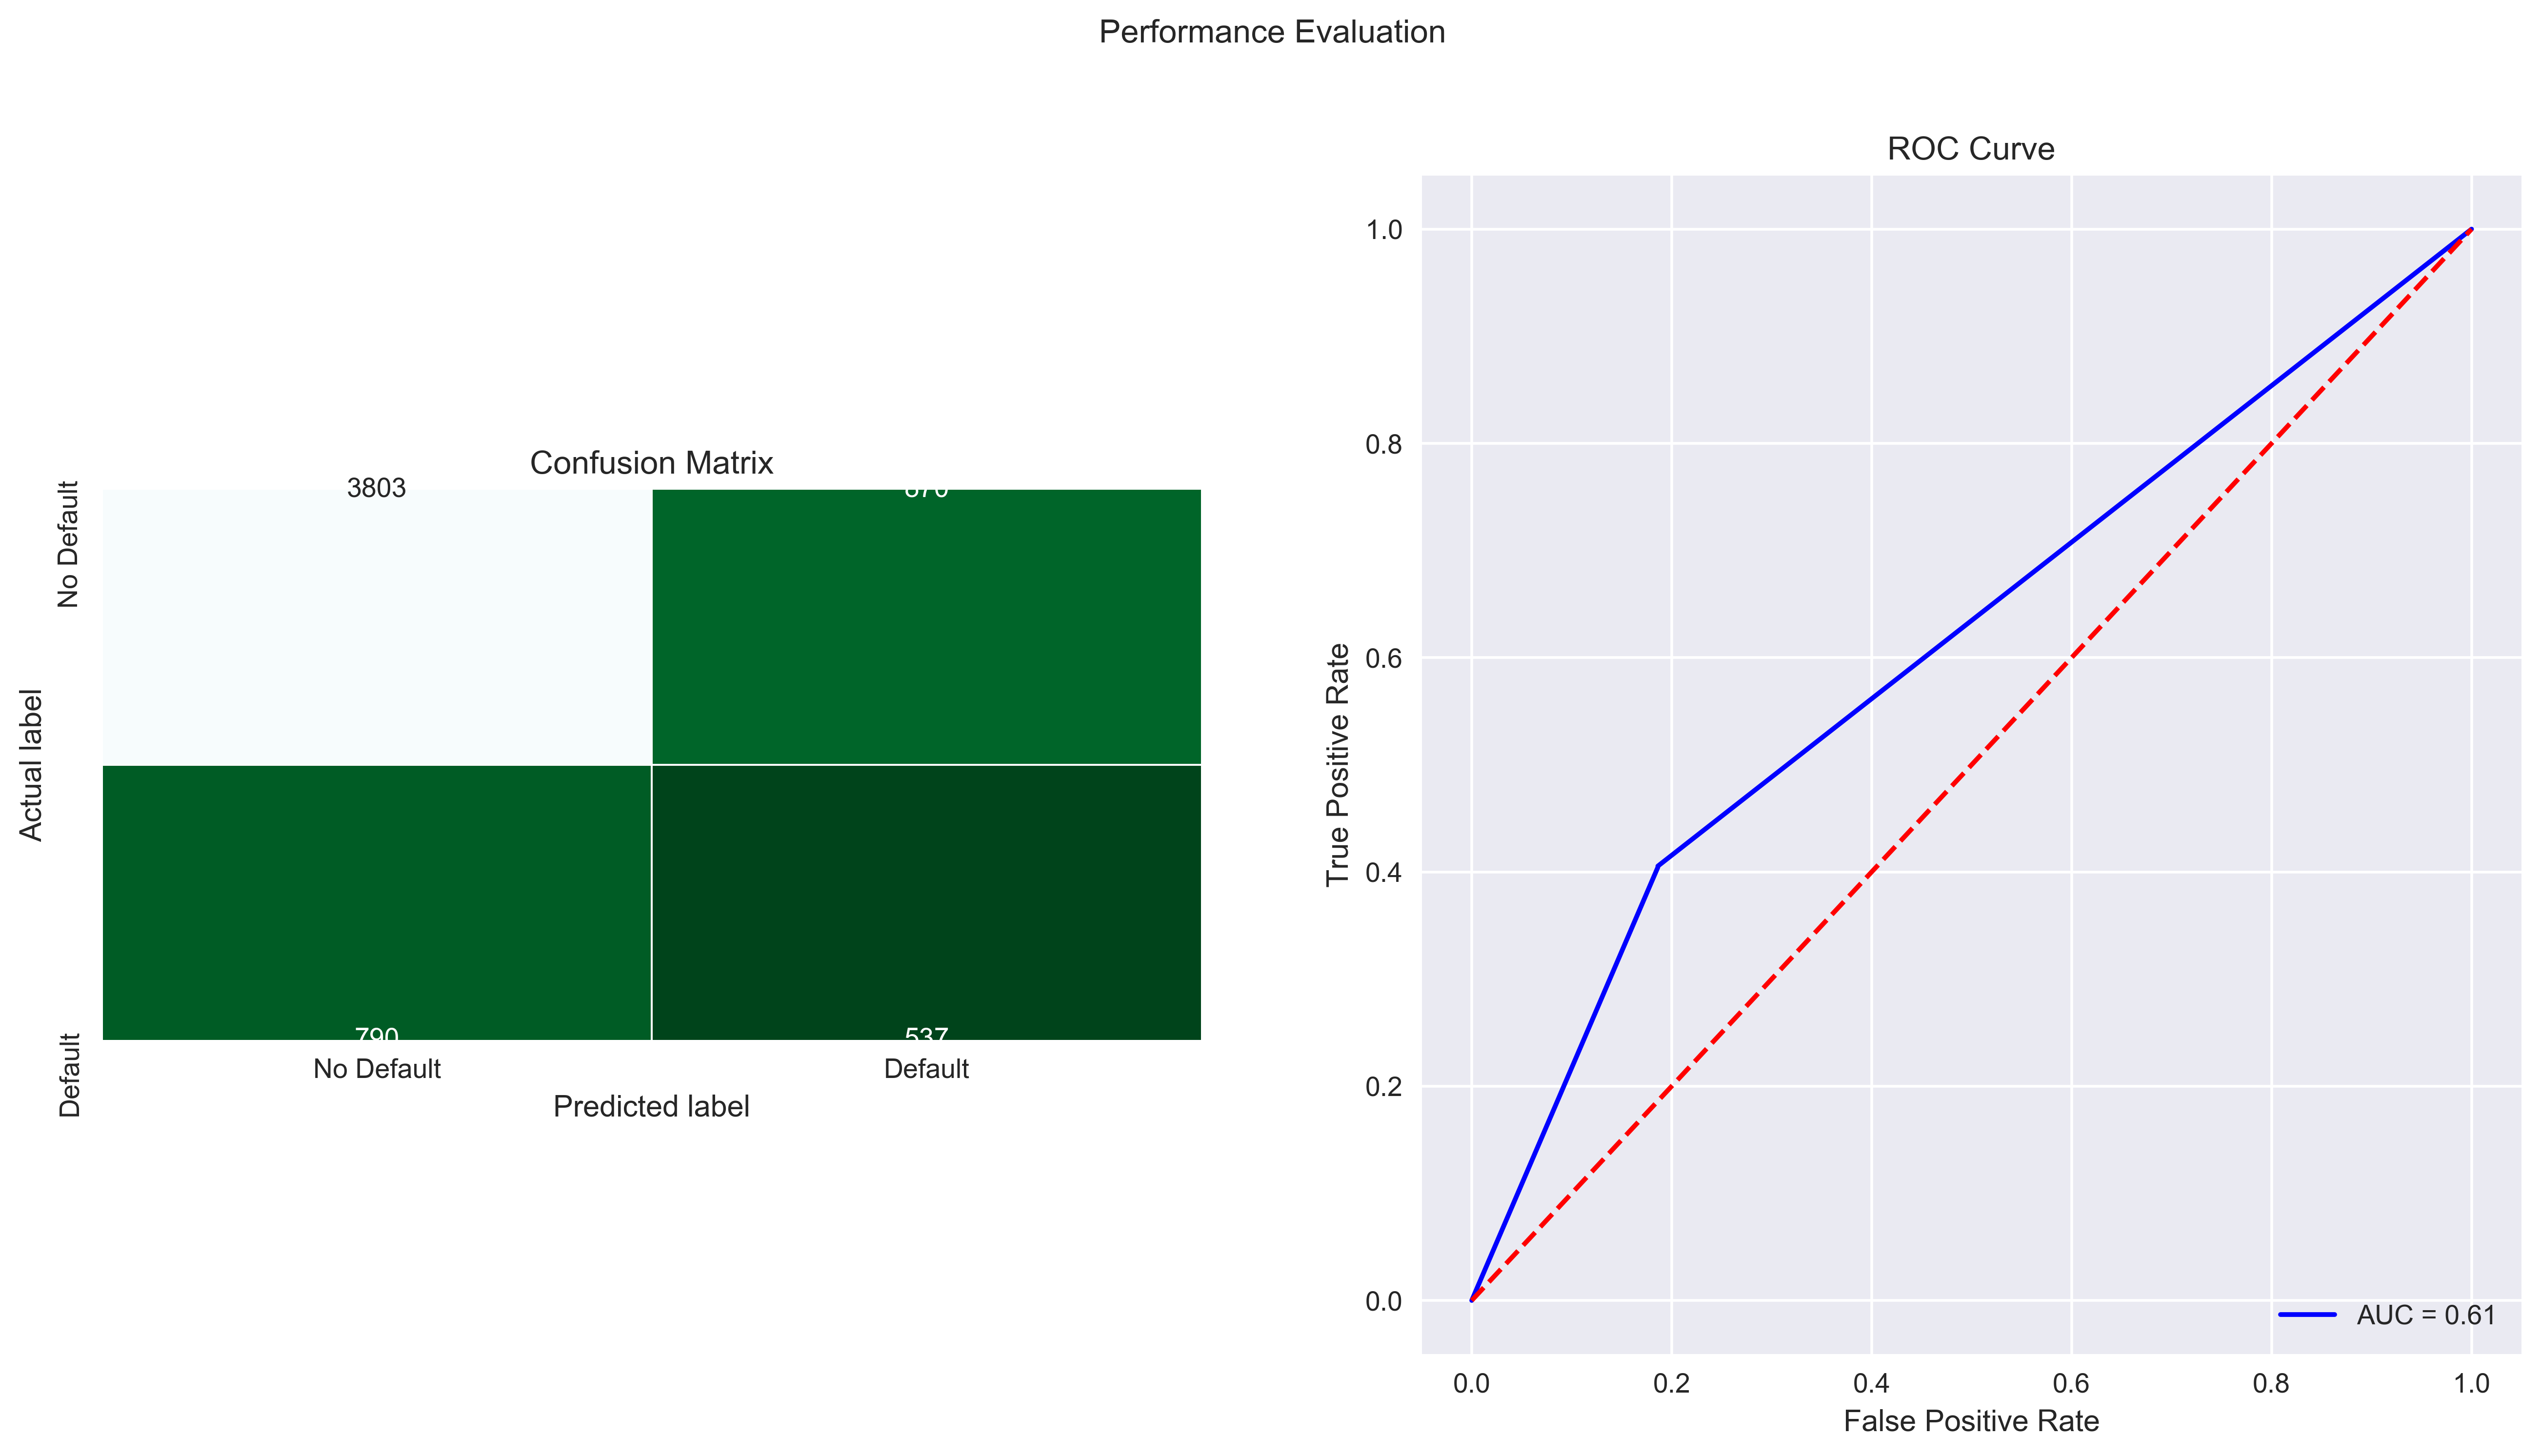

In [14]:
_ = performance_evaluation_report(tree_pipeline, X_test, y_test, labels = ['No Default', 'Default'])

### There's more

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

In [16]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std
    
    def fit(self, X, y = None):
        
        if np.isnan(X).any(axis=None):
            raise ValueError("There are missing values in the array! Please remove them.")

        mean_vec = np.mean(X, axis=0)
        std_vec = np.std(X, axis=0)
        
        self.upper_band_ = mean_vec + self.n_std * std_vec
        self.lower_band_ = mean_vec - self.n_std * std_vec
        self.n_features_ = len(self.upper_band_)
        
        return self 
    
    def transform(self, X, y = None):
        
        X_copy = pd.DataFrame(X.copy())
        
        upper_band = np.repeat(self.upper_band_.reshape(self.n_features_, -1), len(X_copy), axis=1).transpose()
        lower_band = np.repeat(self.lower_band_.reshape(self.n_features_, -1), len(X_copy), axis=1).transpose()
        
        X_copy[X_copy >= upper_band] = upper_band
        X_copy[X_copy <= lower_band] = lower_band
        
        return X_copy.values

In [17]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', OutlierRemover())
])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.7203
Precision: 0.3775
Recall (Sensitivity): 0.4077
Specificity: 0.8091
F1-Score: 0.3920


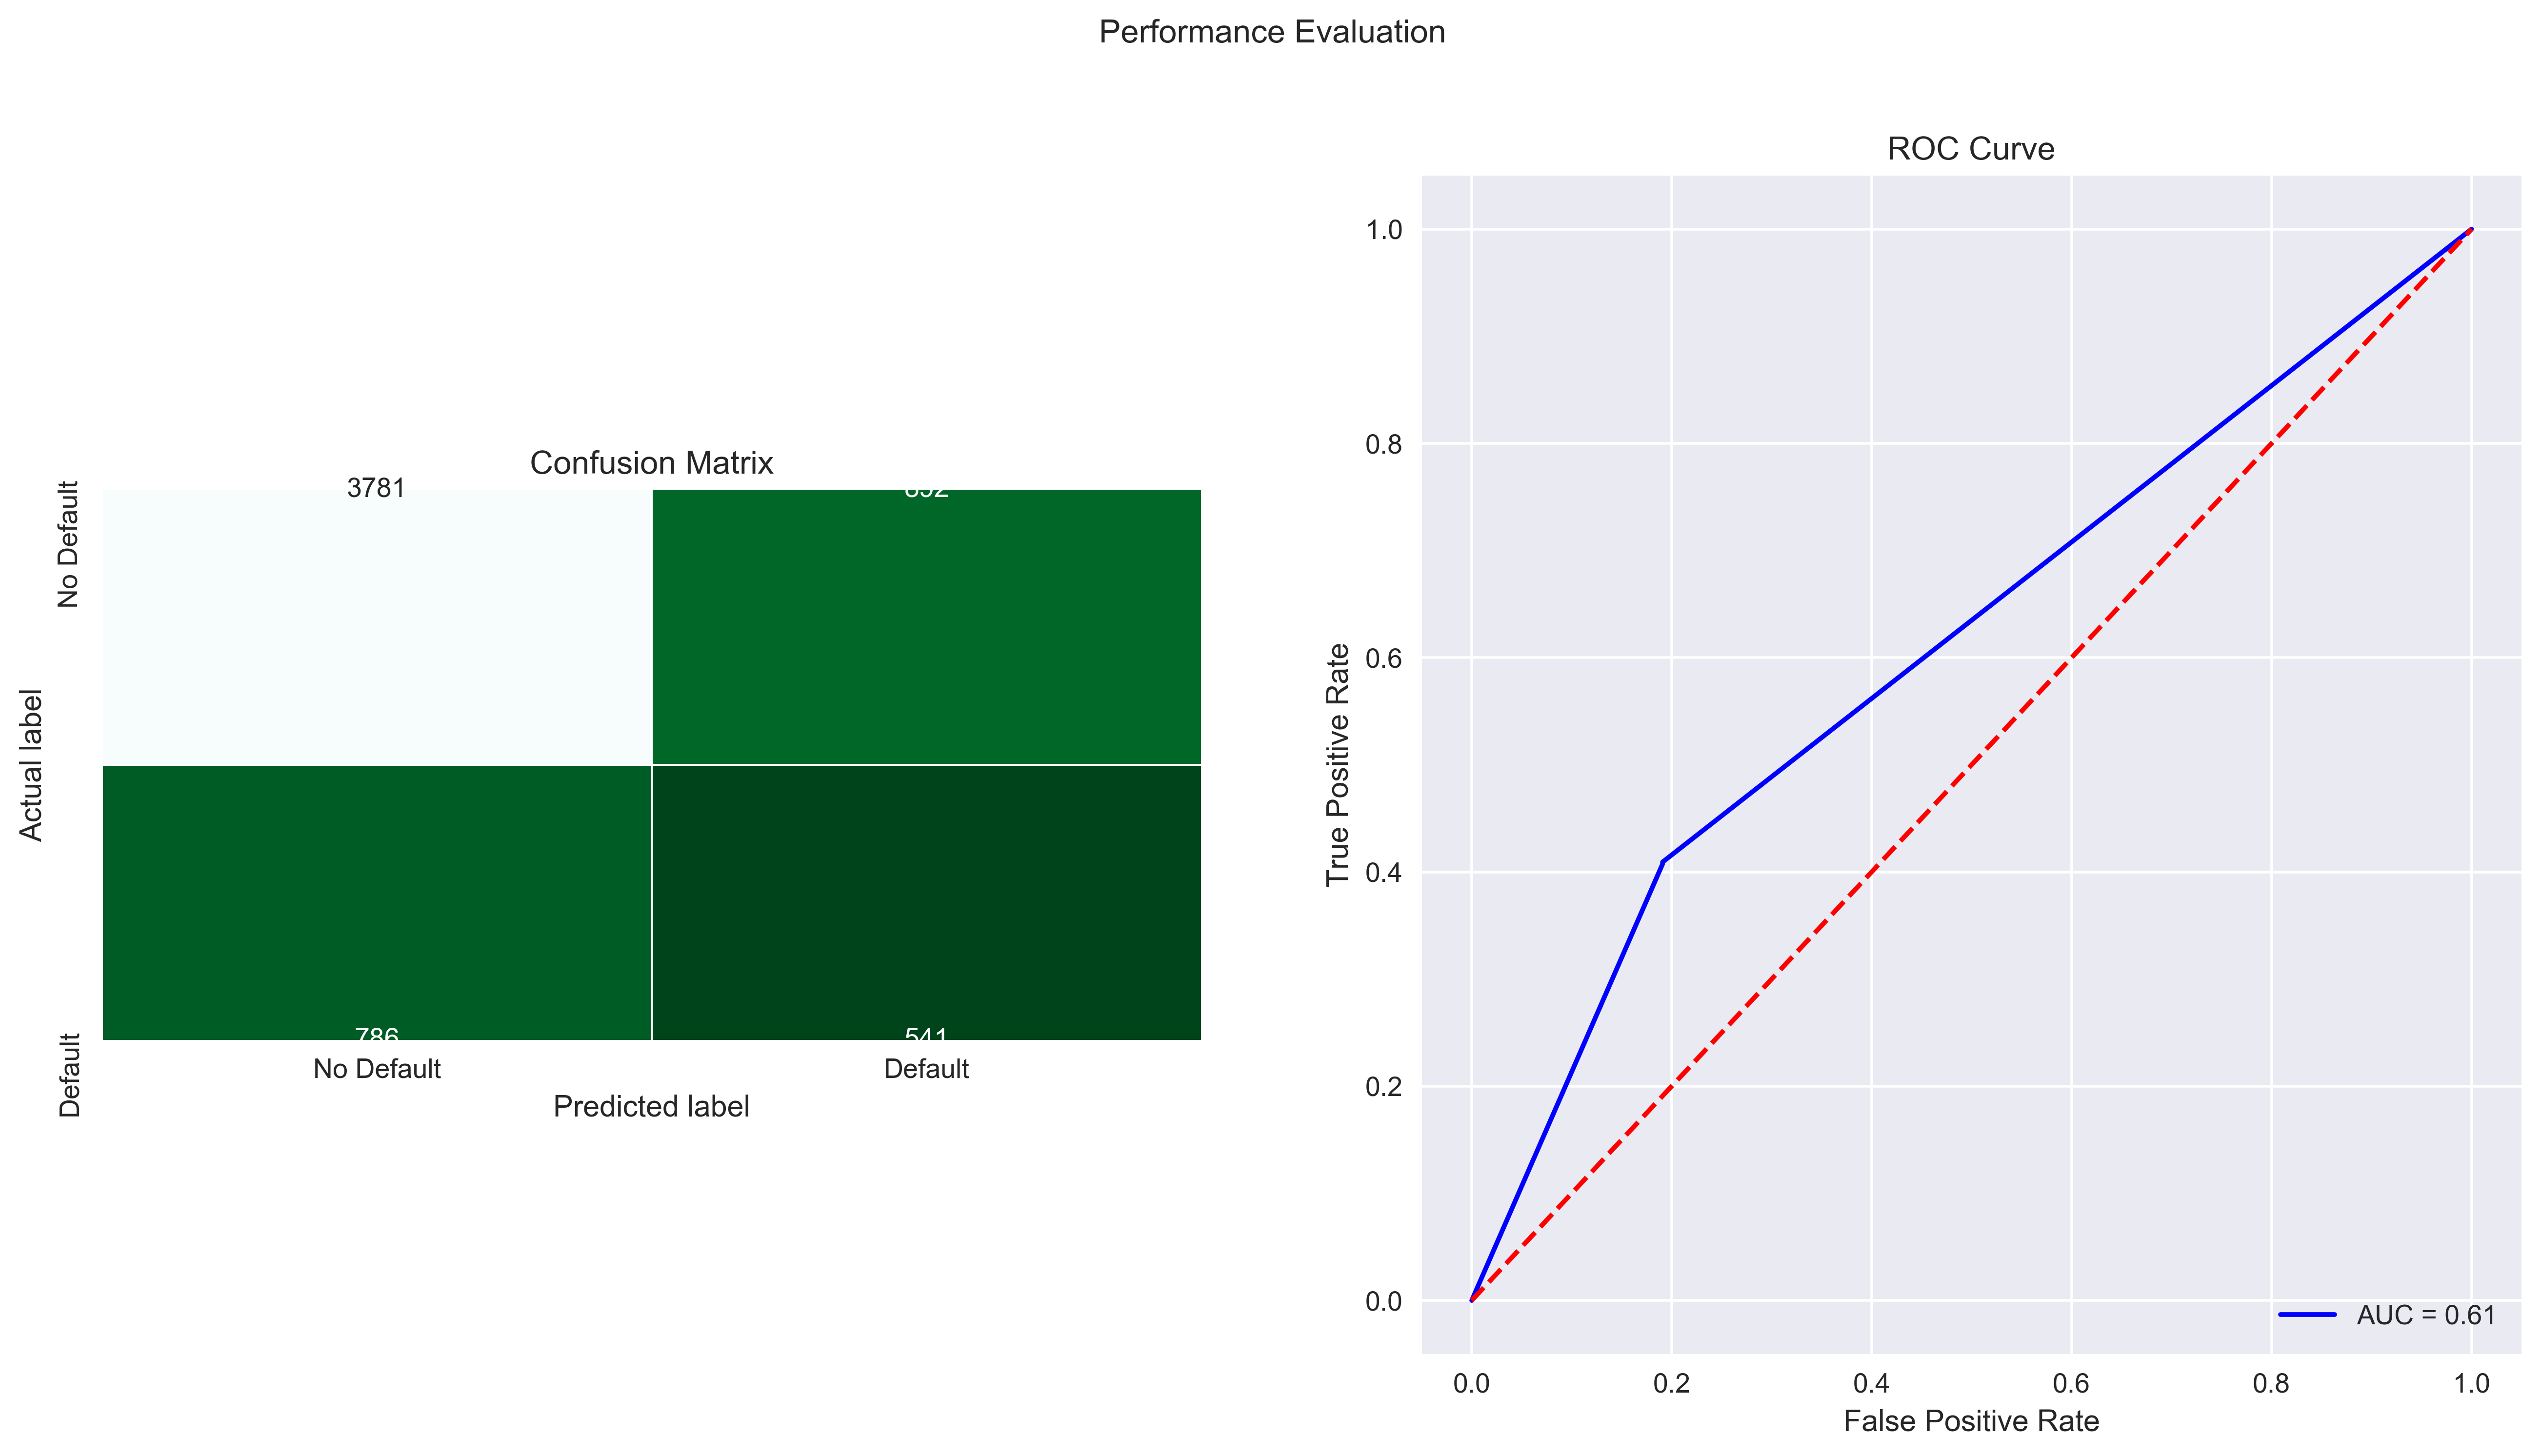

In [18]:
preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, numeric_features),
    ('categorical', categorical_pipeline, categorical_features)],
    remainder='drop')

tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', DecisionTreeClassifier(random_state=42))])

tree_pipeline.fit(X_train, y_train)

dec_tree_perf = performance_evaluation_report(tree_pipeline, X_test, y_test, labels = ['No Default', 'Default'])

## Grid Search and Cross-Validation

### How to do it...

1. Import the required libraries:

In [26]:
from sklearn.model_selection import (GridSearchCV, cross_val_score, RandomizedSearchCV, 
                                     cross_validate, StratifiedKFold)

In [ ]:
%watermark --iversions

2. Define the cross-validation scheme:

In [27]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

3. Evaluate the pipeline using cross-validation:

In [ ]:
cross_val_score(tree_pipeline, X_train, y_train, cv=k_fold)

4. Add extra metrics to cross-validation:

In [ ]:
cross_validate(tree_pipeline, X_train, y_train, cv=k_fold, 
               scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

5. Define the parameter grid:

In [ ]:
param_grid = {'classifier__criterion': ['entropy', 'gini'],
              'classifier__max_depth': range(3,11),
              'classifier__min_samples_leaf': range(2, 11), 
              'preprocessor__numerical__outliers__n_std': [3, 4]}

6. Run Grid Search:

In [ ]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid, scoring='roc_auc', 
                             cv=k_fold, n_jobs=-1, verbose=1)

classifier_gs.fit(X_train, y_train)

In [ ]:
print(f'Best parameters: {classifier_gs.best_params_}') 
print(f'ROC-AUC (Training set): {classifier_gs.best_score_:.4f}') 
print(f'ROC-AUC (Test set): {metrics.roc_auc_score(y_test, classifier_gs.predict_proba(X_test)[:, 1]):.4f}')

7. Evaluate the performance of the Grid Search:

In [ ]:
dec_tree_gs_perf = performance_evaluation_report(classifier_gs, X_test, y_test, labels = ['No Default', 'Default'])

8. Run Randomized Grid Search:

In [ ]:
classifier_rs = RandomizedSearchCV(tree_pipeline, param_grid, scoring='roc_auc', 
                                   cv=k_fold, n_jobs=-1, verbose=1, 
                                   n_iter=100, random_state=42)
classifier_rs.fit(X_train, y_train)

In [ ]:
print(f'Best parameters: {classifier_rs.best_params_}') 
print(f'ROC-AUC (Training set): {classifier_rs.best_score_:.4f}') 
print(f'ROC-AUC (Test set): {metrics.roc_auc_score(y_test, classifier_rs.predict_proba(X_test)[:, 1]):.4f}')

9. Evaluate the performance of the Randomized Grid Search:

In [ ]:
dec_tree_rs_perf = performance_evaluation_report(classifier_rs, X_test, y_test, labels = ['No Default', 'Default'])

### There's more

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
param_grid = [{'classifier': [LogisticRegression()],
               'classifier__penalty': ['l1', 'l2'],
               'classifier__C': np.logspace(0, 3, 10, 2),
               'preprocessor__numerical__outliers__n_std': [3, 4]},
              {'classifier': [DecisionTreeClassifier()],
               'classifier__criterion': ['entropy', 'gini'],
               'classifier__max_depth': range(3,11),
               'classifier__min_samples_leaf': range(2, 11),
               'preprocessor__numerical__outliers__n_std': [3, 4]}]

In [ ]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid, scoring='roc_auc', 
                             cv=k_fold, n_jobs=-1, verbose=1)

classifier_gs.fit(X_train, y_train)

print(f'Best parameters: {classifier_gs.best_params_}') 
print(f'ROC-AUC (Training set): {classifier_gs.best_score_:.4f}') 
print(f'ROC-AUC (Test set): {metrics.roc_auc_score(y_test, classifier_gs.predict_proba(X_test)[:, 1]):.4f}')

## Investigating advanced classifiers

### How to do it...

1. Import the required libraries:

In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

/Users/eryklewinson/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [ ]:
%watermark --iversions

2. Create a Random Forest Pipeline:

#######################
Evaluation metrics ####
#######################
Accuracy: 0.8082
Precision: 0.6290
Recall (Sensitivity): 0.3233
Specificity: 0.9459
F1-Score: 0.4271


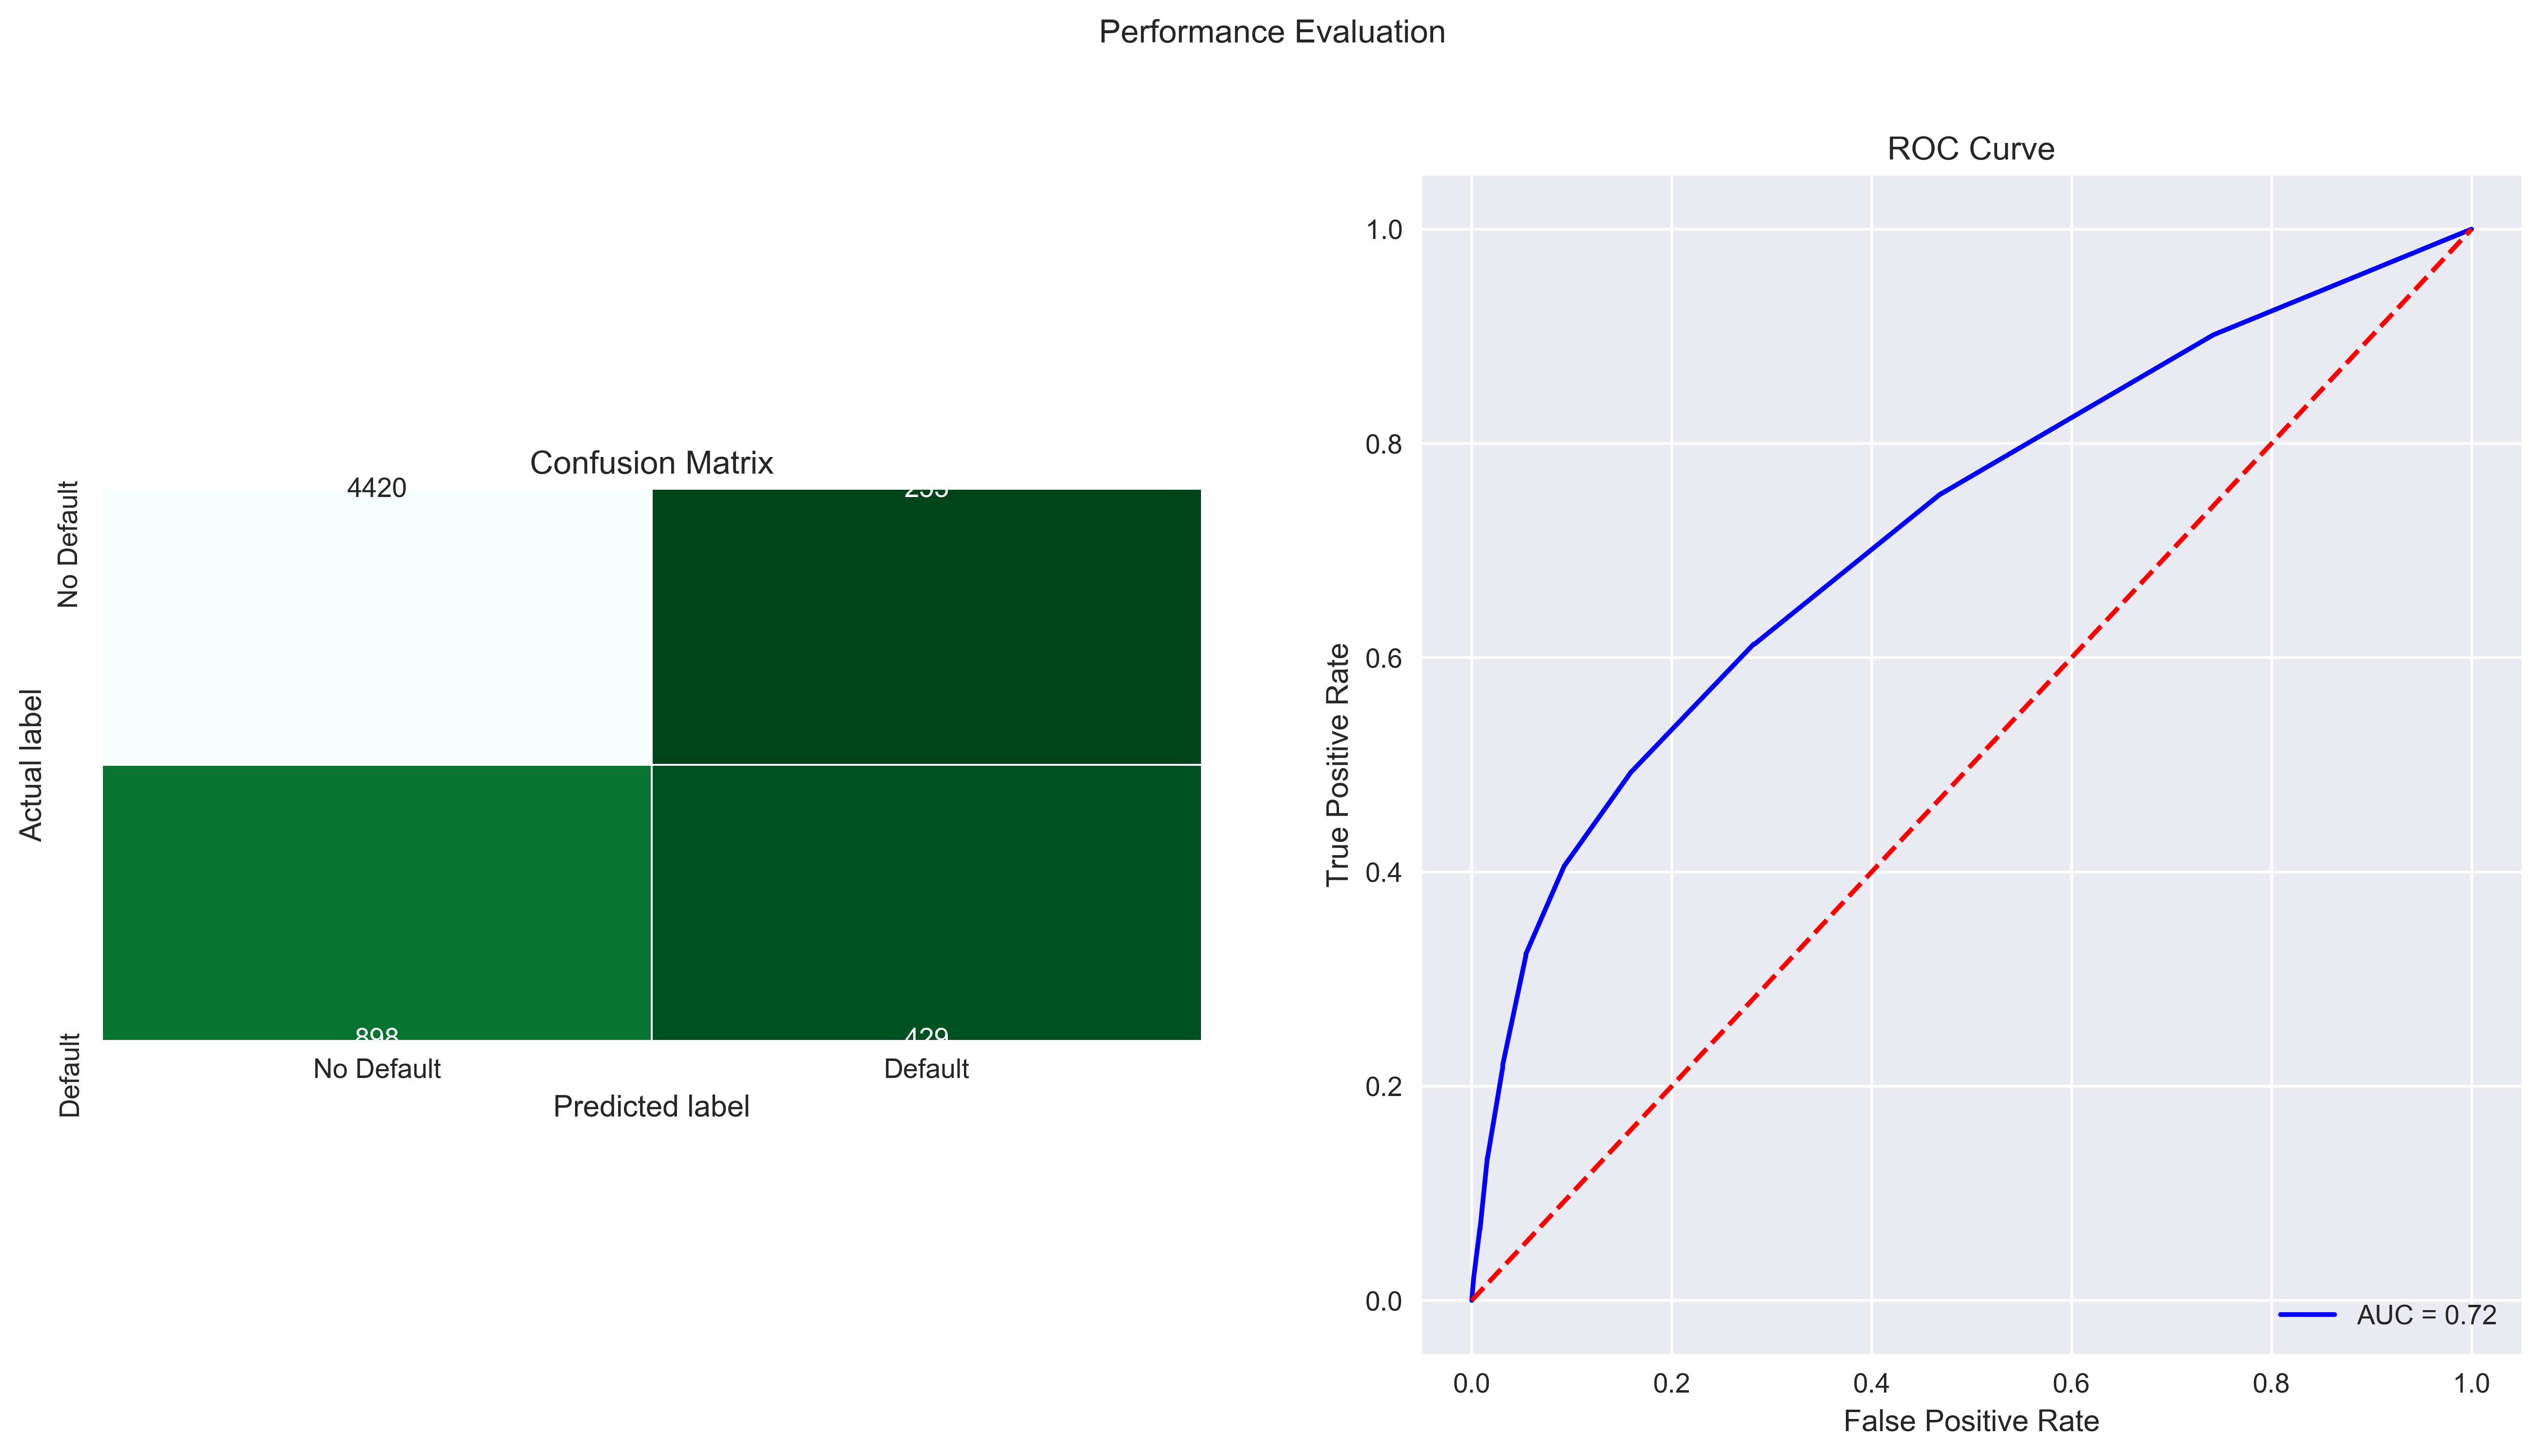

In [32]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

rf_pipeline.fit(X_train, y_train)
rf_perf = performance_evaluation_report(rf_pipeline, X_test, y_test, labels = ['No Default', 'Default'])

3. Create a Gradient Boosting Trees Pipeline:

In [ ]:
gbt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', GradientBoostingClassifier(random_state=42))])

gbt_pipeline.fit(X_train, y_train)
gbt_perf = performance_evaluation_report(gbt_pipeline, X_test, y_test, labels = ['No Default', 'Default'])

4. Create a xgBoost Pipeline:

In [ ]:
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(random_state=42))])

xgb_pipeline.fit(X_train, y_train)
xgb_perf = performance_evaluation_report(xgb_pipeline, X_test, y_test, labels = ['No Default', 'Default'])

5. Create a LightGBM classifier Pipeline:

In [ ]:
lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', LGBMClassifier(random_state=42))])

lgbm_pipeline.fit(X_train, y_train)
lgbm_perf = performance_evaluation_report(lgbm_pipeline, X_test, y_test, labels = ['No Default', 'Default'])

### There's more

In [23]:
from sklearn.model_selection import RandomizedSearchCV
N_SEARCHES = 25

Random Forest

In [24]:
rf_param_grid = {'classifier__n_estimators': np.arange(200, 2000, 200),
                 'classifier__max_features': ['log2', 'sqrt', None],
                 'classifier__max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                 'classifier__min_samples_split': [2, 5, 10],
                 'classifier__min_samples_leaf': np.arange(1, 52, 2, dtype=int),
                 'classifier__bootstrap': [True, False]}

In [28]:
random_forest_rs =  RandomizedSearchCV(rf_pipeline, rf_param_grid, scoring='roc_auc', 
                                       cv=k_fold, n_jobs=-1, verbose=1, 
                                       n_iter=N_SEARCHES, random_state=42)

random_forest_rs.fit(X_train, y_train)

print(f'Best parameters: {random_forest_rs.best_params_}') 
print(f'ROC-AUC (Training set): {random_forest_rs.best_score_:.4f}') 
print(f'ROC-AUC (Test set): {metrics.roc_auc_score(y_test, random_forest_rs.predict_proba(X_test)[:, 1]):.4f}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.7min finished


Best parameters: {'classifier__n_estimators': 1600, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 19, 'classifier__max_features': 'log2', 'classifier__max_depth': 60, 'classifier__bootstrap': False}
ROC-AUC (Training set): 0.7794
ROC-AUC (Test set): 0.7708


In [ ]:
random_forest_rs_perf = performance_evaluation_report(random_forest_rs, X_test, y_test, labels = ['No Default', 'Default'])

Gradient Boosted Trees

In [ ]:
gbt_param_grid = {'classifier__n_estimators': np.arange(100, 500, 100),
                  'classifier__learning_rate': np.arange(0.05, 0.31, 0.05),
                  'classifier__max_depth': np.arange(3, 8, 1, dtype=int),
                  'classifier__min_samples_split': np.linspace(0.1, 0.5, 12),
                  'classifier__min_samples_leaf': np.arange(1, 52, 2, dtype=int),
                  'classifier__max_features':['log2', 'sqrt', None]}

In [ ]:
gbt_rs =  RandomizedSearchCV(gbt_pipeline, gbt_param_grid, scoring='roc_auc', 
                             cv=k_fold, n_jobs=-1, verbose=1, 
                             n_iter=N_SEARCHES, random_state=42)

gbt_rs.fit(X_train, y_train)

print(f'Best parameters: {gbt_rs.best_params_}') 
print(f'ROC-AUC (Training set): {gbt_rs.best_score_:.4f}') 
print(f'ROC-AUC (Test set): {metrics.roc_auc_score(y_test, gbt_rs.predict_proba(X_test)[:, 1]):.4f}')

In [ ]:
gbt_rs_perf = performance_evaluation_report(gbt_rs, X_test, y_test, labels = ['No Default', 'Default'])

xgBoost

In [ ]:
xgb_param_grid = {'classifier__n_estimators': np.arange(100, 1000, 100),
                  'classifier__learning_rate': np.arange(0.05, 0.31, 0.05),
                  'classifier__max_depth': np.arange(3, 16, 1, dtype=int),
                  'classifier__min_child_weight': np.arange(1, 8, 1, dtype=int),
                  'classifier__colsample_bytree': np.linspace(0.3, 1, 7)}

In [ ]:
xgb_rs =  RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring='roc_auc', 
                             cv=k_fold, n_jobs=-1, verbose=1, 
                             n_iter=N_SEARCHES, random_state=42)

xgb_rs.fit(X_train, y_train)

print(f'Best parameters: {xgb_rs.best_params_}') 
print(f'ROC-AUC (Training set): {xgb_rs.best_score_:.4f}') 
print(f'ROC-AUC (Test set): {metrics.roc_auc_score(y_test, xgb_rs.predict_proba(X_test)[:, 1]):.4f}')

In [ ]:
xgb_rs_perf = performance_evaluation_report(xgboost_rs, X_test, y_test, labels = ['No Default', 'Default'])

LightGBM

In [ ]:
lgbm_param_grid = {'classifier__n_estimators': np.arange(100, 1000, 100),
                   'classifier__learning_rate': np.arange(0.05, 0.31, 0.05),
                   'classifier__max_depth': np.arange(3, 16, 1, dtype=int),
                   'classifier__min_child_weight': np.arange(1, 8, 1, dtype=int),
                   'classifier__colsample_bytree': np.linspace(0.3, 1, 7)}

In [ ]:
lgbm_rs =  RandomizedSearchCV(lgbm_pipeline, lgbm_param_grid, scoring='roc_auc', 
                              cv=k_fold, n_jobs=-1, verbose=1, 
                              n_iter=N_SEARCHES, random_state=42)

lgbm_rs.fit(X_train, y_train)

print(f'Best parameters: {lgbm_rs.best_params_}') 
print(f'ROC-AUC (Training set): {lgbm_rs.best_score_:.4f}') 
print(f'ROC-AUC (Test set): {metrics.roc_auc_score(y_test, lgbm_rs.predict_proba(X_test)[:, 1]):.4f}')

In [ ]:
lgbm_rs_perf = performance_evaluation_report(lgbm_rs, X_test, y_test, labels = ['No Default', 'Default'])

In [ ]:
results_dict = {'decision_tree_baseline': dec_tree_perf,
                'decision_tree_gs': dec_tree_gs_perf,
                'decision_tree_rs': dec_tree_rs_perf,
                'random_forest': rf_perf,
                'random_forest_rs': random_forest_rs_perf,
                'gradient_boosted_trees': gbt_perf,
                'gradient_boosted_trees_rs': gbt_rs_perf,
                'xgboost': xgb_perf,
                'xgboost_rs': xgb_rs_perf,
                'light_gbm': lgbm_perf,
                'light_gbm_rs': lgbm_rs_perf}

results_comparison = pd.DataFrame(results_dict).T
results_comparison

## Investigating the feature importance

### How to do it...

1. Import the required libraries:

In [22]:
# from sklearn.inspection import permutation_importance
from sklearn.base import clone 
from eli5.sklearn import PermutationImportance
from eli5 import explain_weights_df

Using TensorFlow backend.


In [ ]:
%watermark --iversions

2. Extract the classifier and preprocessor from the pipeline:

In [33]:
# in case we have the fitted grid search object `random_forest_rs`, we extract the best pipeline
# rf_pipeline = random_forest_rs.best_estimator_

rf_classifier = rf_pipeline.named_steps['classifier']
preprocessor = rf_pipeline.named_steps['preprocessor']

# in case we want to manually assign hyperparameters based on previous grid search
# best_parameters =  {'n_estimators': 400, 'min_samples_split': 2, 
#                     'min_samples_leaf': 49, 'max_features': None, 
#                     'max_depth': 20, 'bootstrap': True, 'random_state': 42}
# rf_classifier = rf_classifier.set_params(**best_parameters)

3. Recover feature names from the preprocessing transformer and transform the training data:

In [55]:
# note: categorical_features and numeric_features were defined in recipe 
# Implementing scikit-learn's pipelines

feature_names = preprocessor.named_transformers_['categorical'] \
                            .named_steps['onehot'] \
                            .get_feature_names(input_features=categorical_features)
feature_names = np.r_[numeric_features, feature_names]

X_train_preprocessed = pd.DataFrame(preprocessor.transform(X_train), columns=feature_names)

4. Extract the default feature importance and calculate the cumulative importance:

In [35]:
rf_feature_importance = pd.DataFrame(rf_classifier.feature_importances_,
                                     index=feature_names,
                                     columns=['mdi'])
rf_feature_importance = rf_feature_importance.sort_values('mdi', ascending=False)
rf_feature_importance['cumulative_importance_mdi'] = np.cumsum(rf_feature_importance.mdi)

5. Define a function for plotting top X features in terms of their importance:

In [51]:
def plot_most_important_features(feature_importances, method='MDI', n_features=10, bottom=False):
    
    if bottom:
        indicator = 'Bottom'
        feature_importances = feature_importances.sort_values(ascending=True)
    else:
        indicator = 'Top'
        feature_importances = feature_importances.sort_values(ascending=False)
        
    ax = feature_importances.head(n_features).plot.barh()
    ax.invert_yaxis()
    ax.set(title=f'Feature importance - {method} ({indicator} {n_features})', xlabel='Importance', ylabel='Feature');

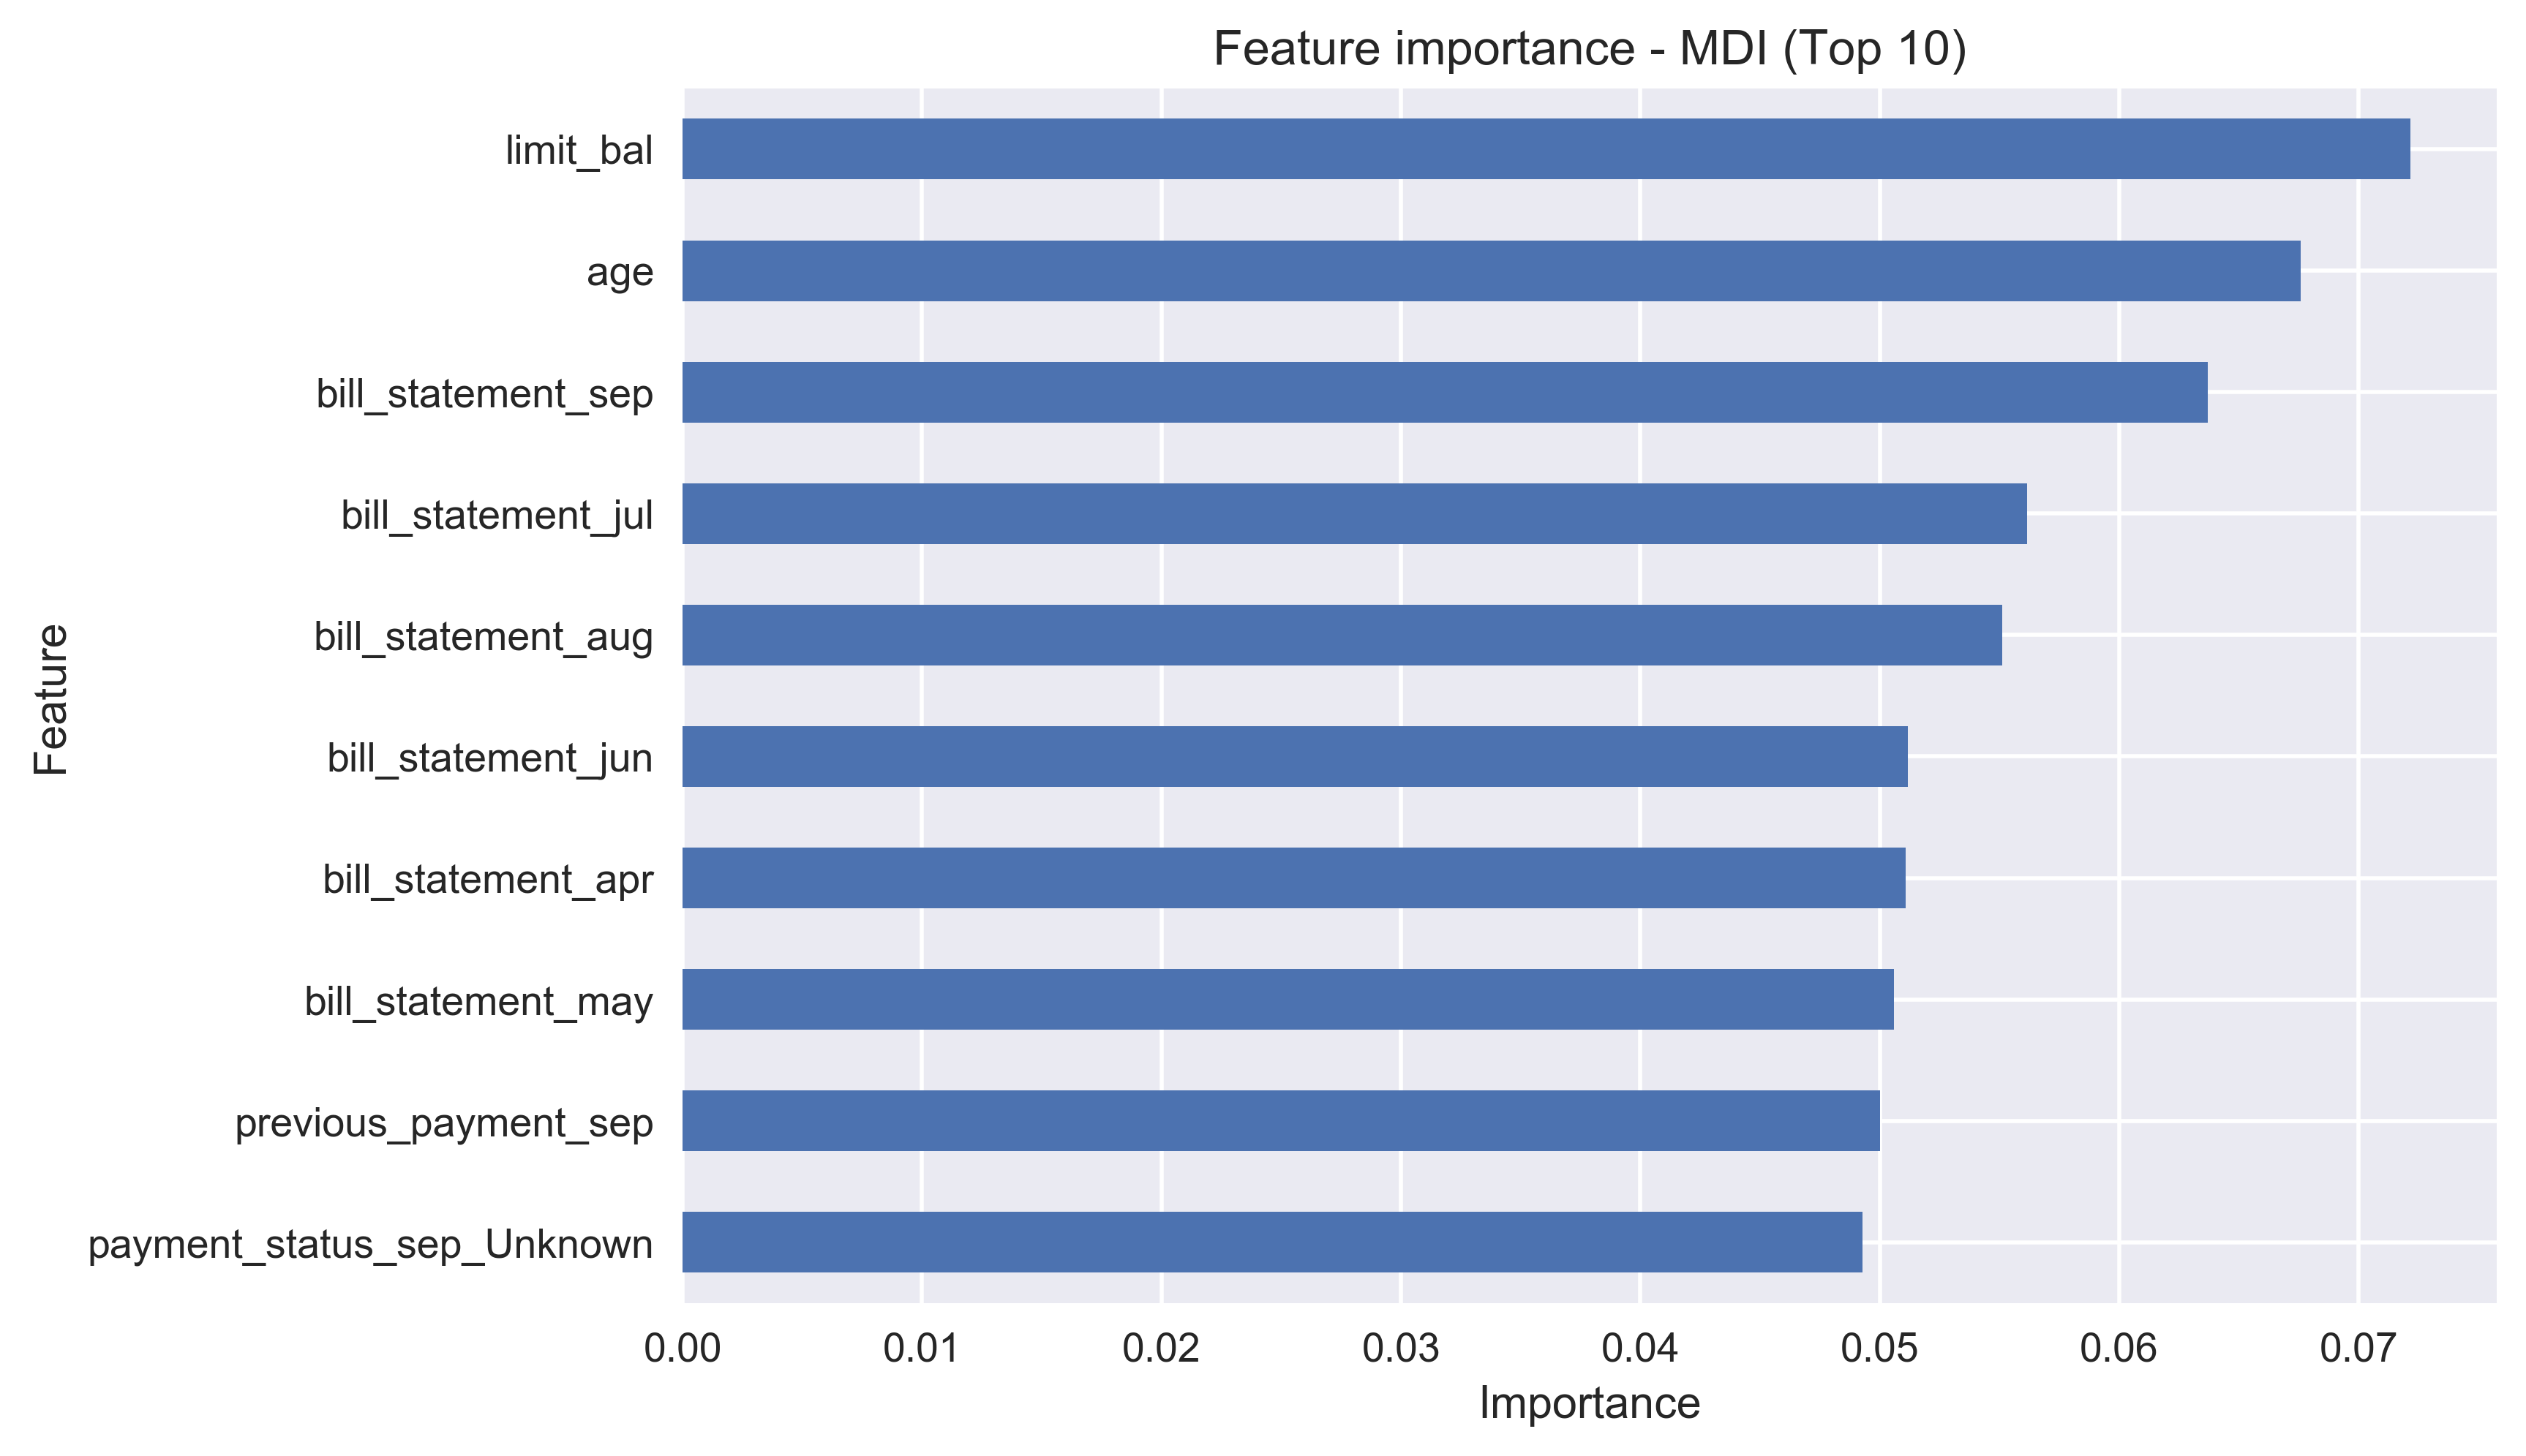

In [48]:
plot_most_important_features(rf_feature_importance.mdi, method='MDI')

6. Plot the cumulative importance of the features:

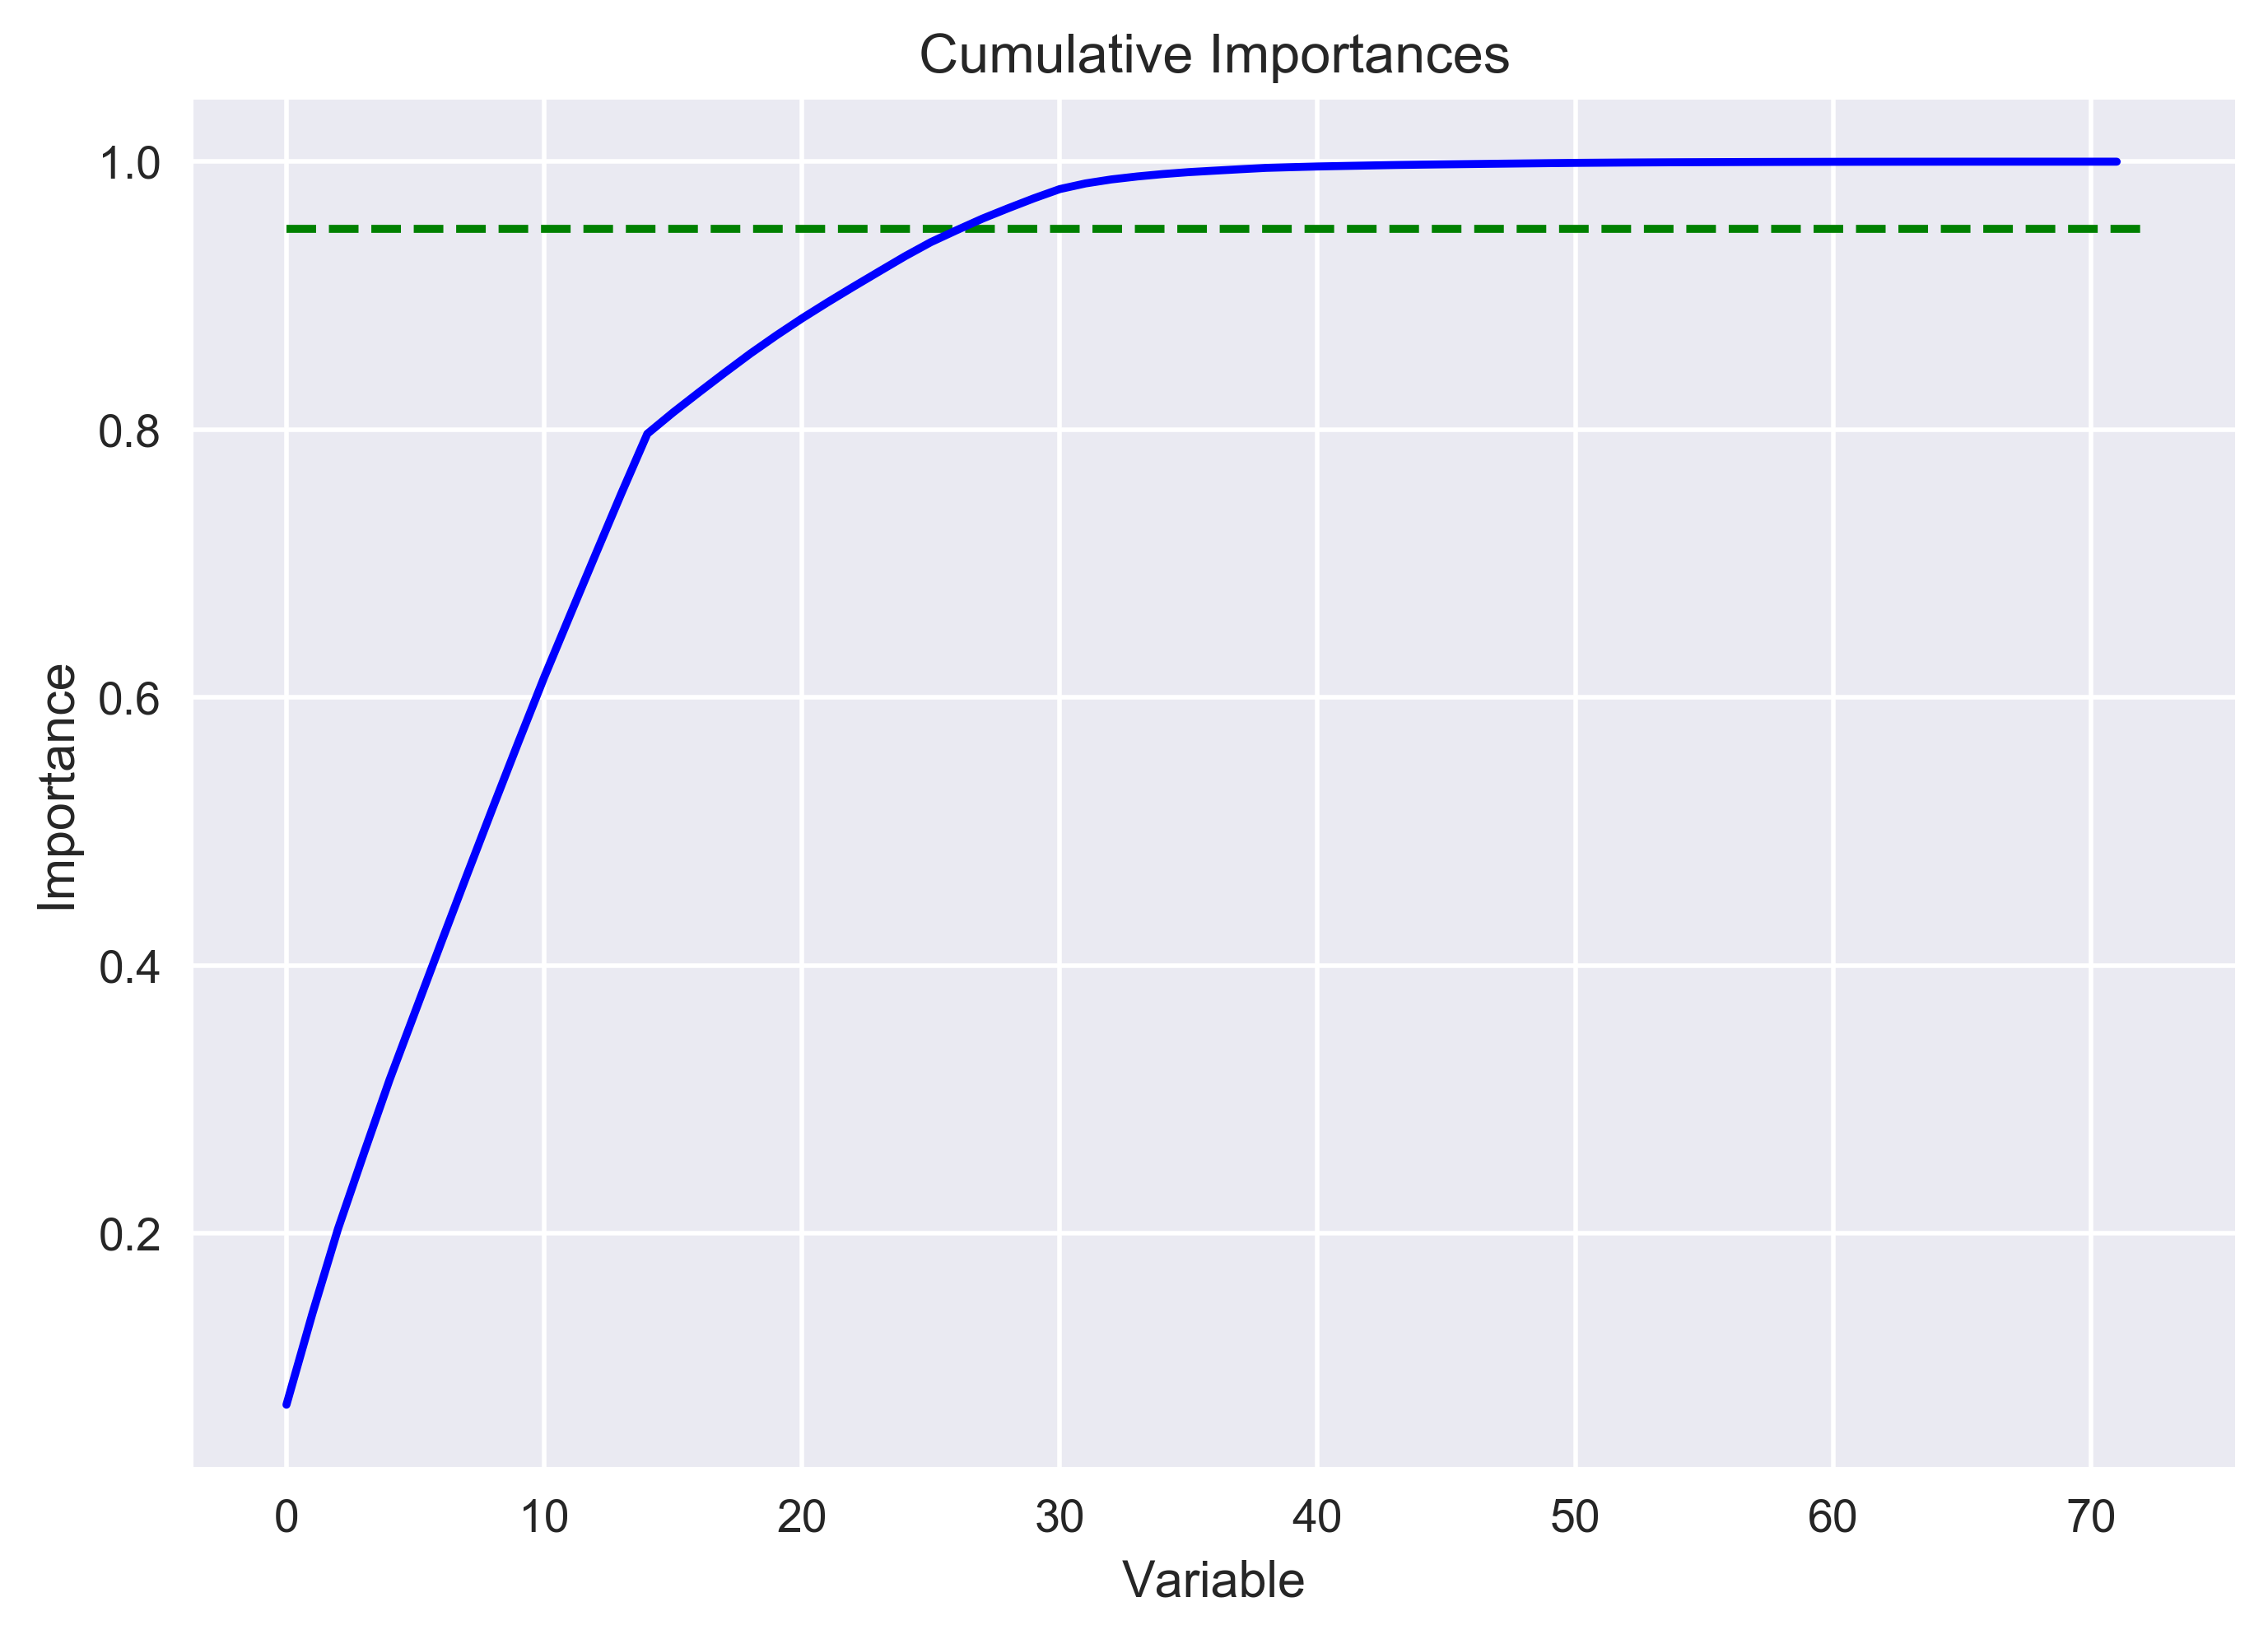

In [66]:
fig, ax = plt.subplots()
ax.plot(x_values, rf_feature_importance.cumulative_importance_mdi, 'b-')
ax.hlines(y = 0.95, xmin=0, xmax=len(x_values), color = 'g', linestyles = 'dashed')
ax.set(title='Cumulative Importances', xlabel='Variable', ylabel='Importance');

In [67]:
print(f'Top 10 features account for {100 * rf_feature_importance.head(10).mdi.sum():.2f}% of the total importance.')
print(f'Top {rf_feature_importance[rf_feature_importance.cumulative_importance_mdi <= 0.95].shape[0]} features account for 95% of importance.')

Top 10 features account for 56.68% of the total importance.
Top 27 features account for 95% of importance.


7. Calculate and plot permutation importance:

In [41]:
perm = PermutationImportance(rf_classifier, n_iter = 25, random_state=42)
perm.fit(X_train_preprocessed, y_train)
rf_feature_importance['permutation'] = perm.feature_importances_

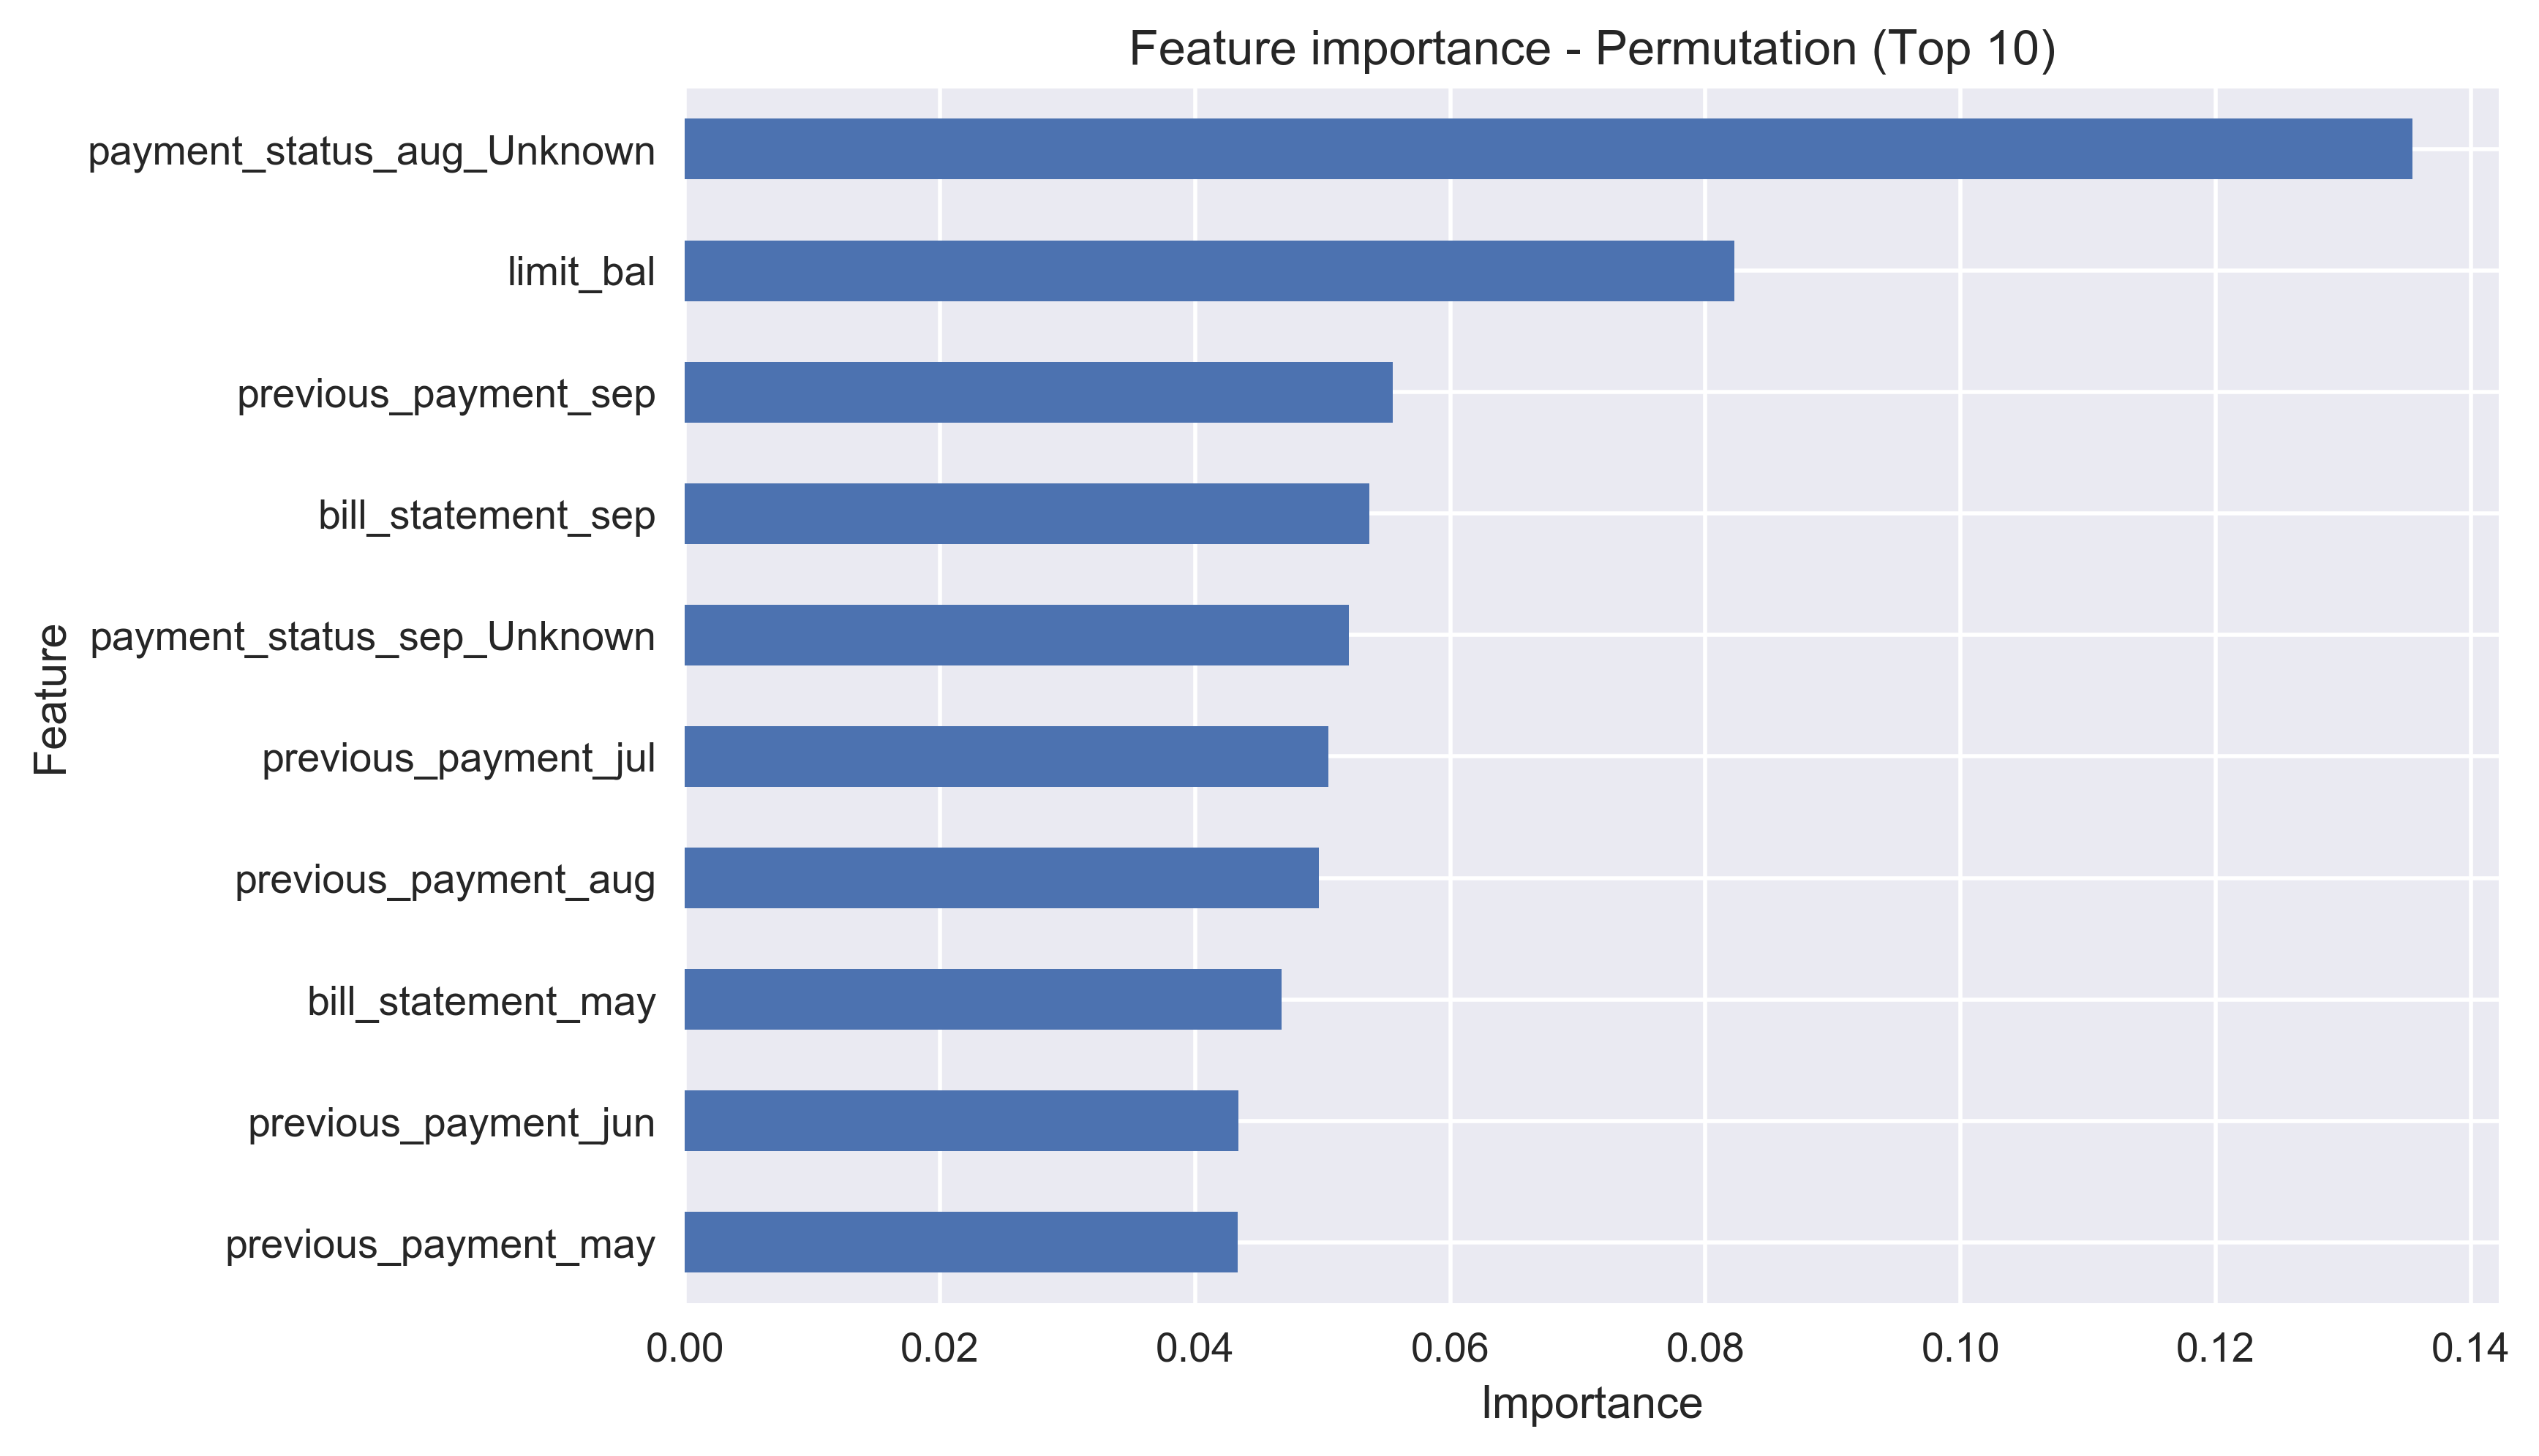

In [60]:
plot_most_important_features(rf_feature_importance.permutation, method='Permutation')

8. Define a function for calculating the drop-column feature importance:

In [43]:
def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    model_clone = clone(model)
    model_clone.random_state = random_state
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    
    importances = []
    
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    return importances

9. Calculate and plot the drop-column feature importance:

In [44]:
rf_feature_importance['drop_column'] = drop_col_feat_imp(rf_classifier, X_train_preprocessed, y_train, random_state = 42)

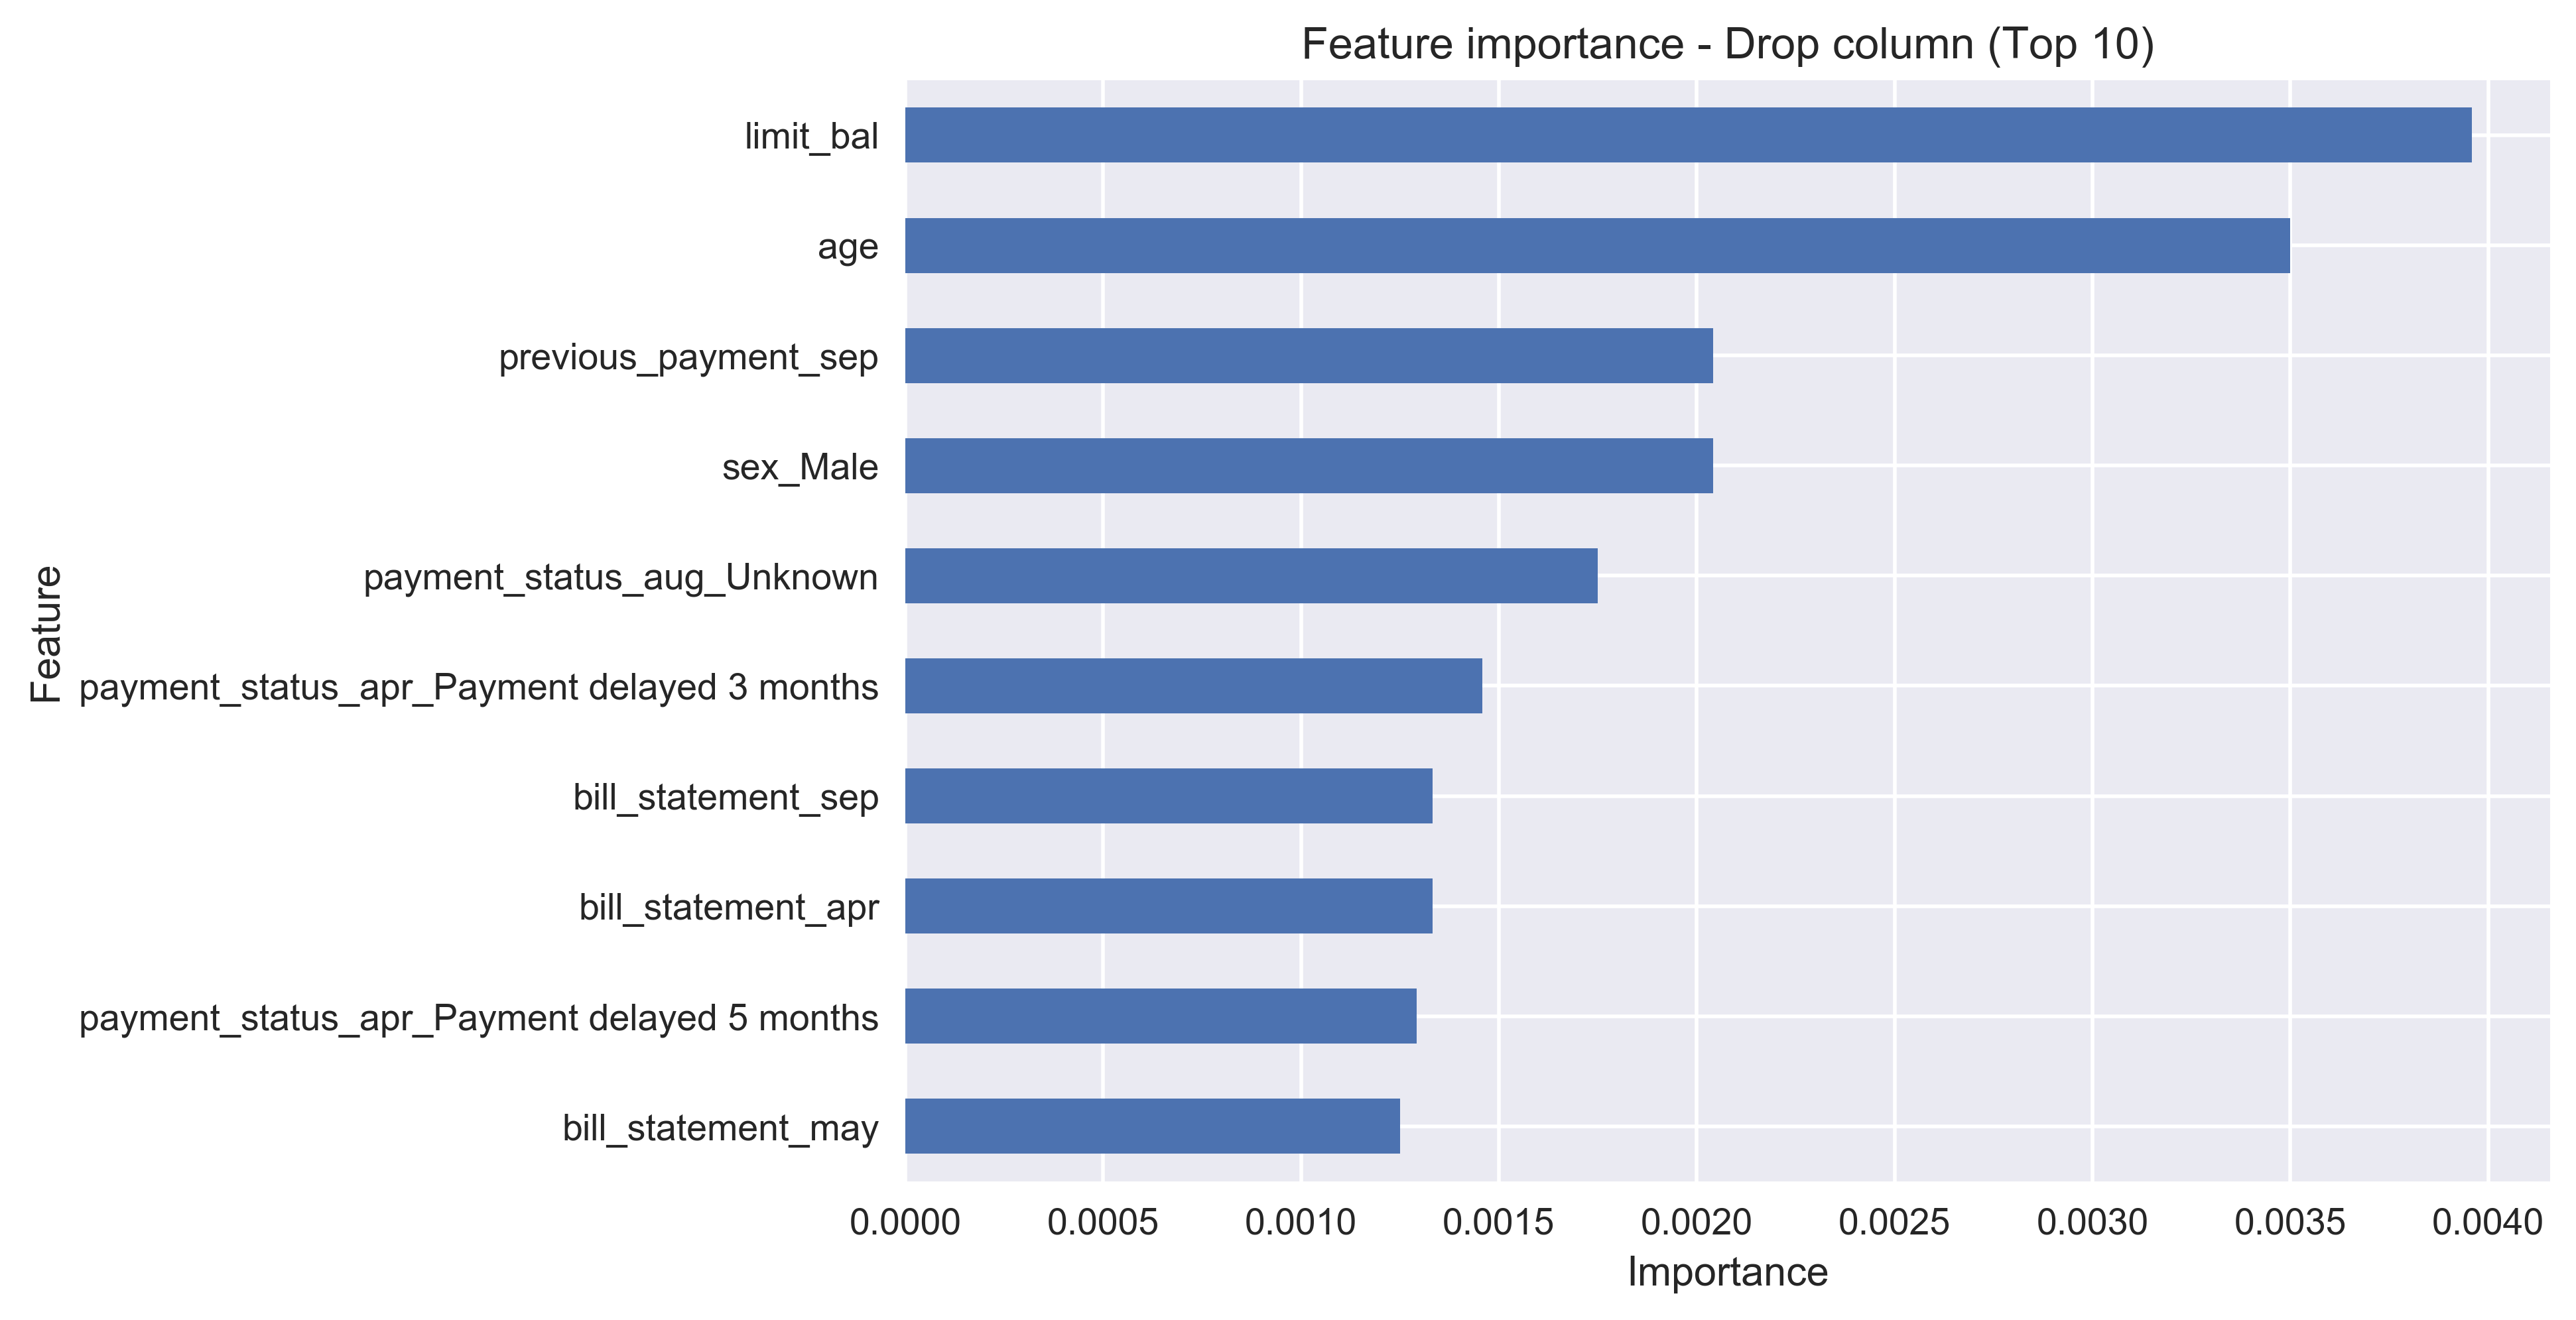

In [53]:
plot_most_important_features(rf_feature_importance.drop_column, method='Drop column')

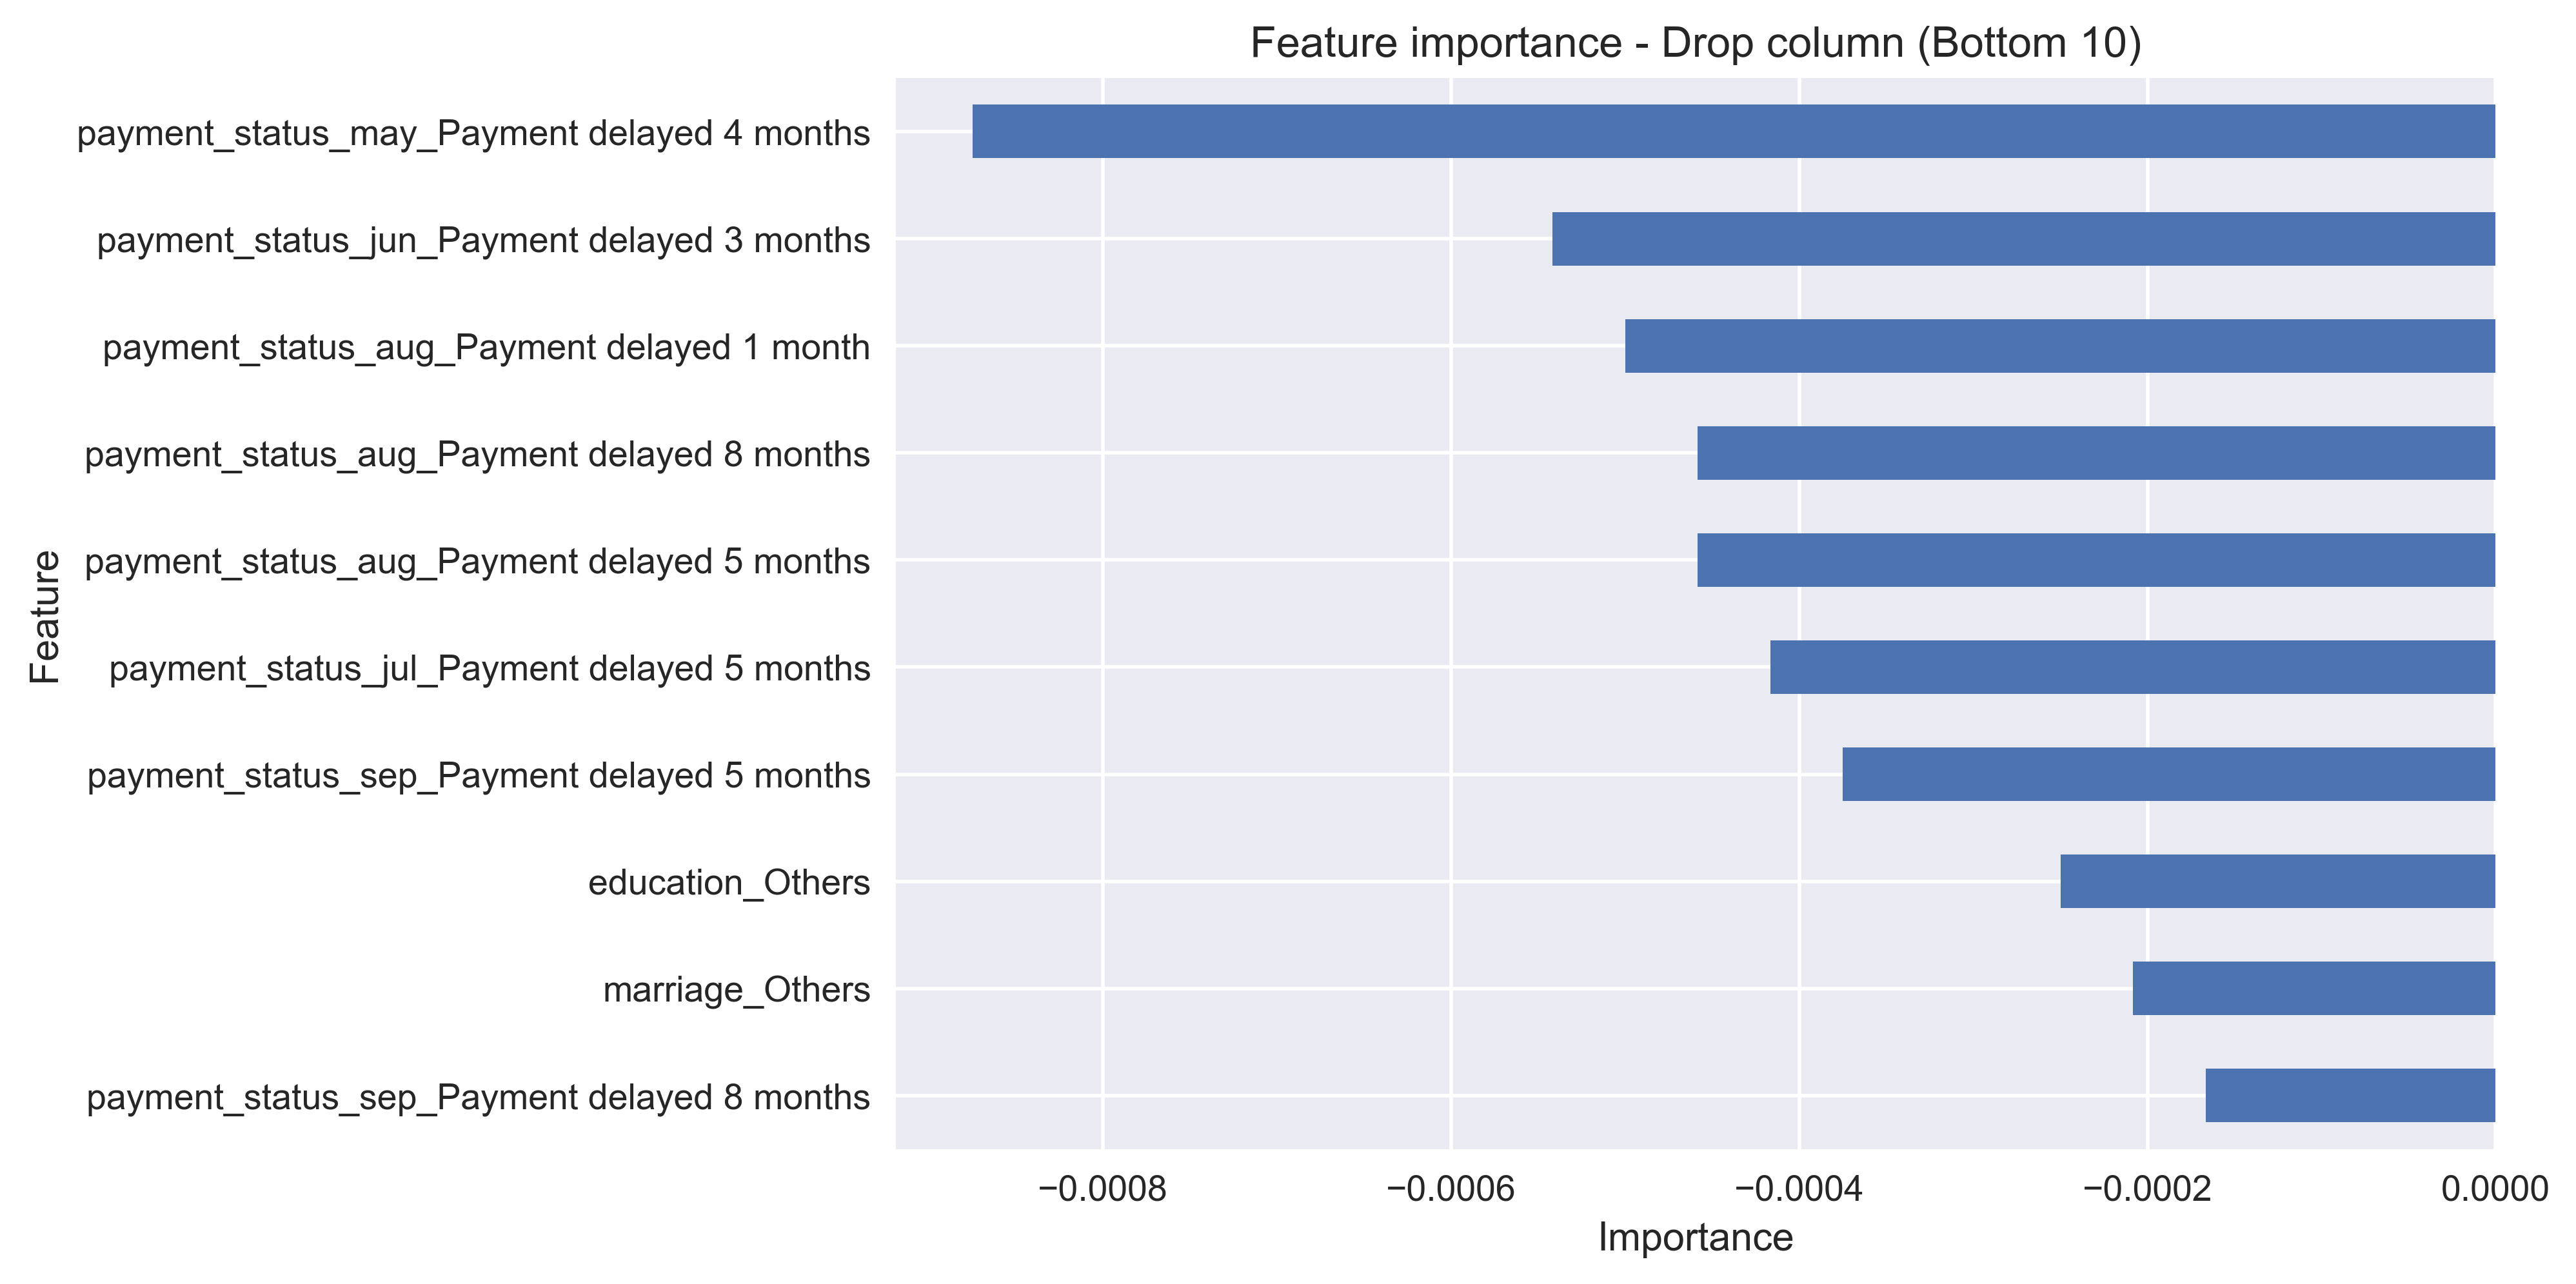

In [54]:
plot_most_important_features(rf_feature_importance.drop_column, method='Drop column', bottom=True)